# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


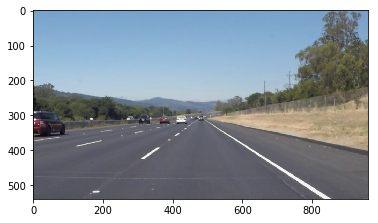

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    x_left = []
    y_left = []
    x_right = []
    y_right = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:            
            if (((y2 - y1) == 0) and (x2 - x1) == 0):                 
                continue
                
            # Calculate slope    
            m = (y2 - y1)/(x2 - x1)
            
            if(np.isnan(float(m))):                                
                continue
            
            if(abs(m) < 0.3):
                continue
            
            if(m > 0):
                x_right.append(x1)
                y_right.append(y1)
                x_right.append(x2)
                y_right.append(y2)
            elif m < 0:
                x_left.append(x1)
                y_left.append(y1)
                x_left.append(x2)
                y_left.append(y2)
            
    
    try:
        left_lane= np.polyfit(x_left,y_left,1)
        right_lane= np.polyfit(x_right,y_right,1)

        print('left_lane:',left_lane)
        print('right_lane:',right_lane)

        intersect_y_top=330
        intersect_y_bottom=540

        x_left_max=round(int((intersect_y_top-left_lane[1])/left_lane[0]))
        x_left_min=round(int((intersect_y_bottom-left_lane[1])/left_lane[0]))
        print('x_left_max:',x_left_max)
        print('x_left_min:',x_left_min)

        x_right_max=abs(int((intersect_y_bottom-right_lane[1])/right_lane[0]))
        x_right_min=abs(int((intersect_y_top-right_lane[1])/right_lane[0]))
        print('x_right_max:',x_right_max)
        print('x_right_min:',x_right_min)       
        
        # Draw left/right lane line
        cv2.line(img,(x_left_max,intersect_y_top),(x_left_min,intersect_y_bottom),color,thickness)
        cv2.line(img,(x_right_min,intersect_y_top),(x_right_max,intersect_y_bottom),color,thickness)
    except:
        pass
    
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    draw_lines(line_img, lines)
    
    return line_img

# Python 3 has support for cool math symbols.

def weighted_image(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 '.ipynb_checkpoints',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

This image is: solidWhiteCurve.jpg with dimensions: (540, 960, 3)
left_lane: [  -0.77125031  679.78970102]
right_lane: [  0.56263316  38.72472243]
x_left_max: 453
x_left_min: 181
x_right_max: 890
x_right_min: 517
This image is: whiteCarLaneSwitch.jpg with dimensions: (540, 960, 3)
left_lane: [  -0.76715382  681.32311145]
right_lane: [  0.57556533  34.96841326]
x_left_max: 457
x_left_min: 184
x_right_max: 877
x_right_min: 512
This image is: solidWhiteRight.jpg with dimensions: (540, 960, 3)
left_lane: [  -0.69665052  643.23151705]
right_lane: [ 0.63937223  1.29699761]
x_left_max: 449
x_left_min: 148
x_right_max: 842
x_right_min: 514
This image is: solidYellowCurve.jpg with dimensions: (540, 960, 3)
left_lane: [  -0.71354453  654.13415371]
right_lane: [  0.60919917  21.19691082]
x_left_max: 454
x_left_min: 159
x_right_max: 851
x_right_min: 506
This image is: solidYellowCurve2.jpg with dimensions: (540, 960, 3)
left_lane: [  -0.741439    664.11208847]
right_lane: [  0.58353106  32.5588679

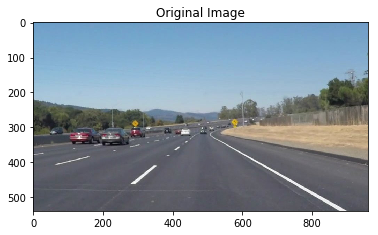

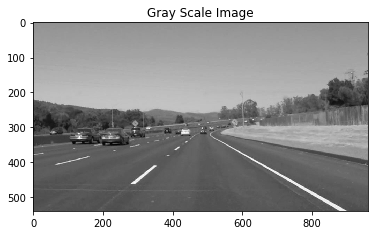

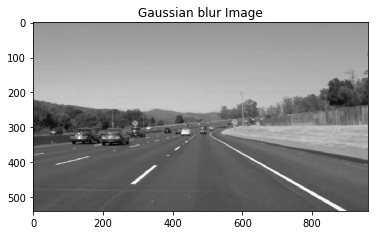

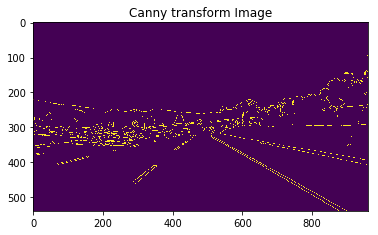

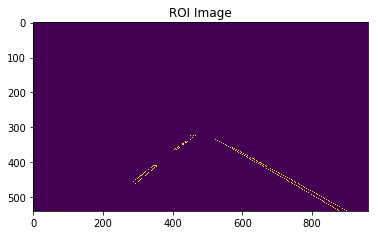

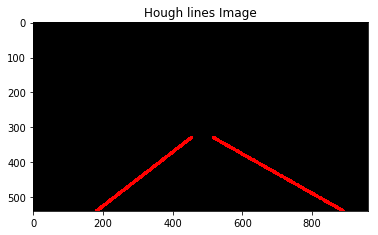

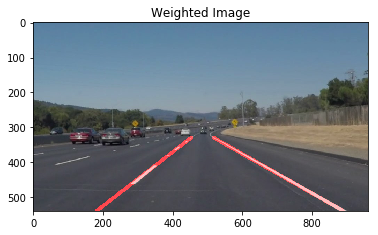

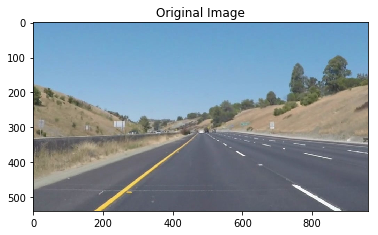

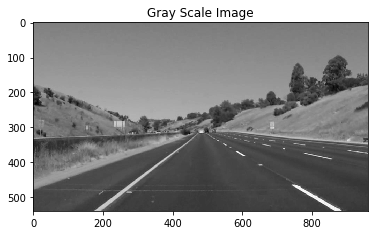

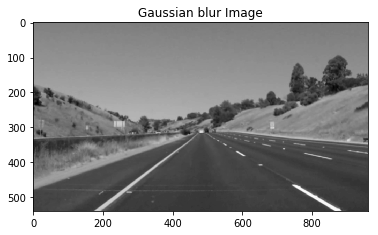

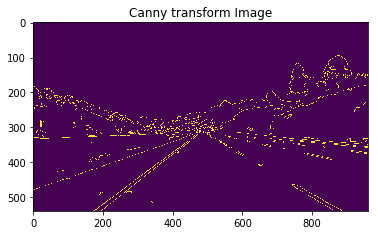

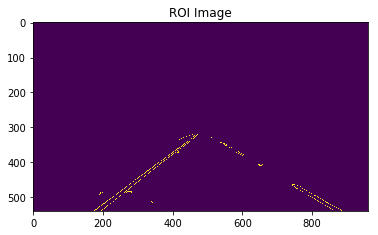

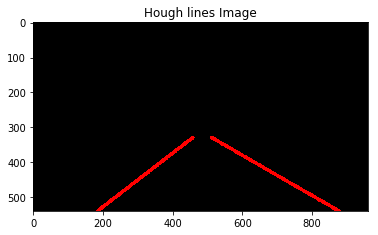

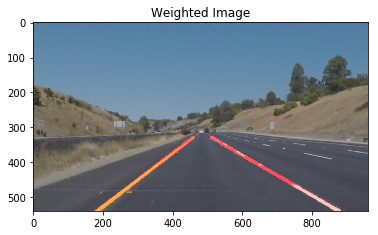

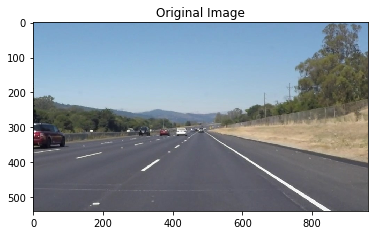

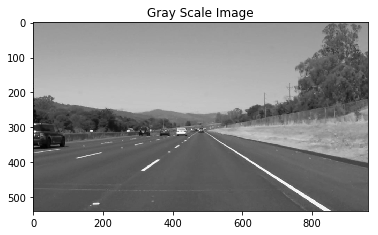

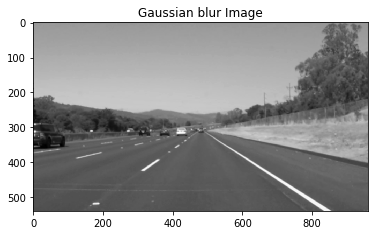

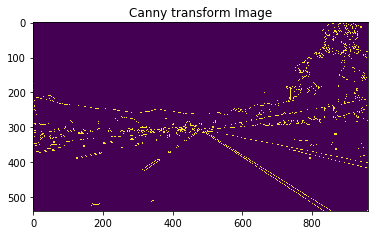

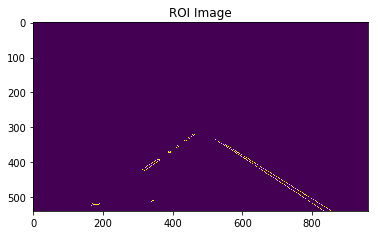

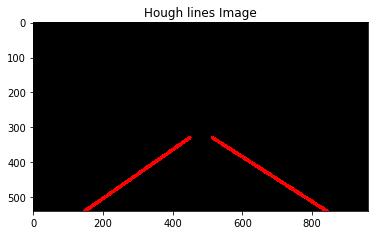

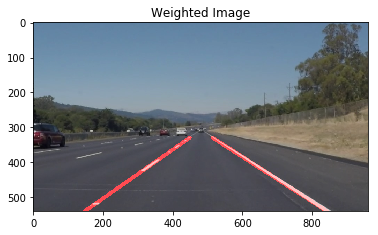

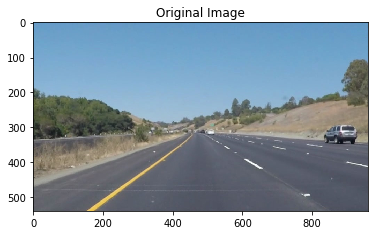

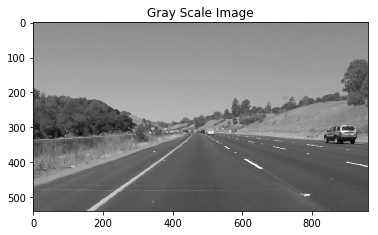

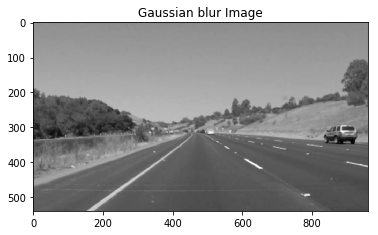

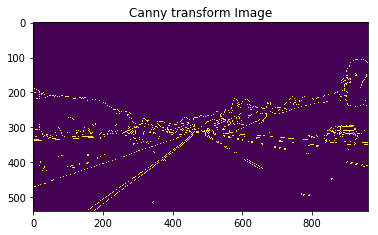

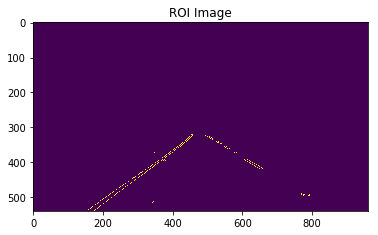

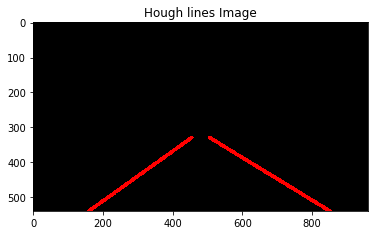

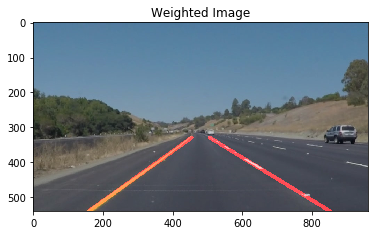

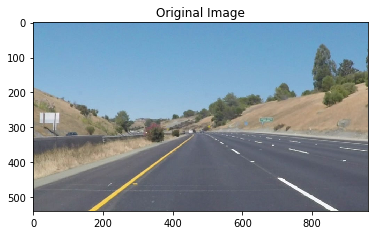

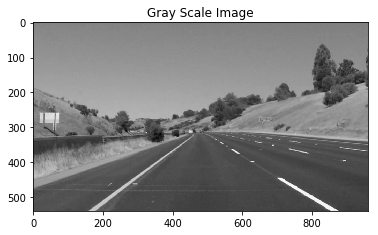

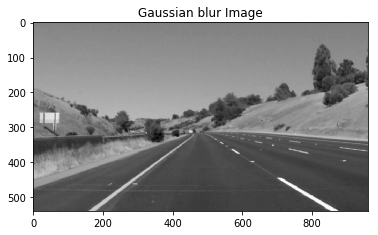

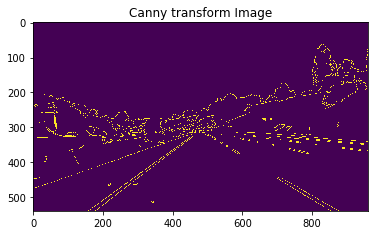

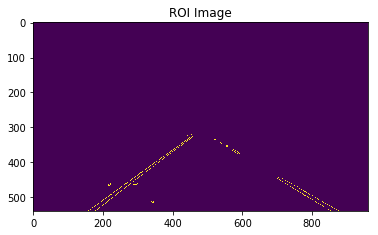

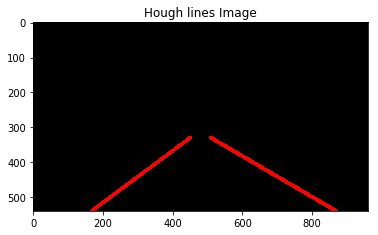

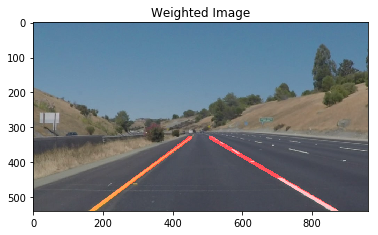

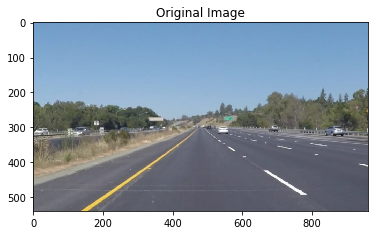

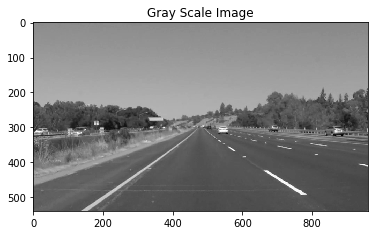

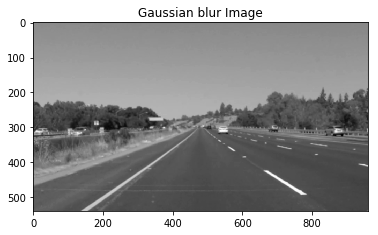

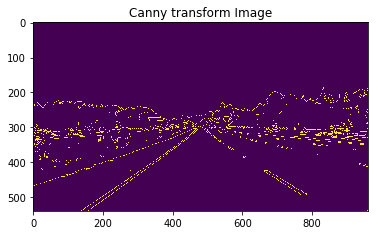

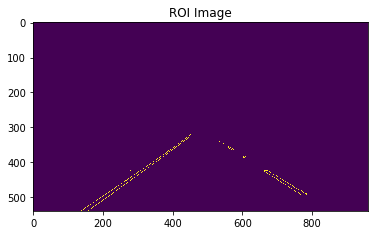

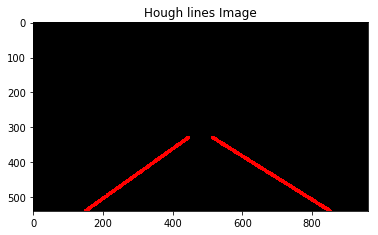

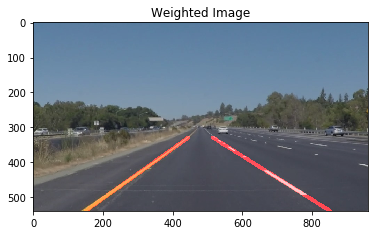

In [34]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

# lane line draw images
test_images = []

# reading in an image (filter by extension)
file_list = os.listdir('test_images/')
images = [file for file in file_list if file.endswith(".jpg")]

# make output directory
output_dir_name = 'test_images_output/'
os.makedirs(output_dir_name,exist_ok=True)

for image in images:
    read_image = mpimg.imread('test_images/'+image)  
    
    # printing out some stats and plotting
    print('This image is:', image, 'with dimensions:', read_image.shape)
    plt.figure()
    plt.title("Original Image")
    plt.imshow(read_image)
    
    # Applies the Grayscale transform
    gray_image = grayscale(read_image)
    plt.figure()
    plt.title("Gray Scale Image")
    plt.imshow(gray_image, cmap='gray')
    
    # Save gray scale image
    img_name = 'gray_' + image
    cv2.imwrite(output_dir_name + img_name, gray_image)
    
    # Applies a Gaussian Noise kernel
    kernel_size = 5
    gaussian_blur_image = gaussian_blur(gray_image, kernel_size)
    plt.figure()
    plt.title("Gaussian blur Image")
    plt.imshow(gaussian_blur_image, cmap='gray')
    
    # Save gaussian blur image
    img_name = 'blur_' + image
    cv2.imwrite(output_dir_name + img_name, gaussian_blur_image)
        
    # Applies the Canny transform
    low_threshold = 50
    high_threshold = 100
    canny_image = canny(gaussian_blur_image, low_threshold, high_threshold)
    plt.figure()
    plt.title("Canny transform Image")
    plt.imshow(canny_image)
    
    # Save canny edge image
    img_name = 'canny_' + image    
    cv2.imwrite(output_dir_name + img_name, canny_image)
    
    # Applies an image mask
    imshape = read_image.shape
    vertices = np.array([[(0,imshape[0]),(450, 320), (490, 320), (imshape[1],imshape[0])]], dtype=np.int32)    
    roi_image = region_of_interest(canny_image, vertices) 
    plt.figure()
    plt.title("ROI Image")
    plt.imshow(roi_image)
    
    # Save roi image
    img_name = 'roi_' + image    
    cv2.imwrite(output_dir_name + img_name, roi_image)
    
    # Draw hough lines
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi / 180 # angular resolution in radians of the Hough grid
    threshold = 50 # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 1 #minimum number of pixels making up a line
    max_line_gap = 250 # maximum gap in pixels between connectable line segments  
    
    hough_lines_image = hough_lines(roi_image, rho, theta, threshold, min_line_len, max_line_gap)
    plt.figure()
    plt.title("Hough lines Image")
    plt.imshow(hough_lines_image)  
    
    # Save hough lines image
    img_name = 'hough_' + image 
    output_image = cv2.cvtColor(hough_lines_image,cv2.COLOR_RGB2BGR) # Change color order
    cv2.imwrite(output_dir_name + img_name, output_image)
    
    output_image = weighted_image(hough_lines_image, read_image)
    plt.figure()
    plt.title("Weighted Image")
    plt.imshow(output_image)
    
    # Save output images
    img_name = 'weighted_' + image
    output_image = cv2.cvtColor(output_image,cv2.COLOR_RGB2BGR) # Change color order
    cv2.imwrite(output_dir_name + img_name, output_image)    
    
    

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**
'''

In [35]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [36]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
      
    # Applies the Grayscale transform
    gray_image = grayscale(image)    
    
    # Applies a Gaussian Noise kernel
    kernel_size = 5
    gaussian_blur_image = gaussian_blur(gray_image, kernel_size)  
    
    # Applies the Canny transform
    low_threshold = 50
    high_threshold = 200
    canny_image = canny(gaussian_blur_image, low_threshold, high_threshold) 
    
    # Applies an image mask
    imshape = read_image.shape
    vertices = np.array([[(0,imshape[0]),(450, 320), (490, 320), (imshape[1],imshape[0])]], dtype=np.int32)    
    roi_image = region_of_interest(canny_image, vertices)
    
    # Draw hough lines
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi / 180 # angular resolution in radians of the Hough grid
    threshold = 50 # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 1 #minimum number of pixels making up a line
    max_line_gap = 250 # maximum gap in pixels between connectable line segments     
    hough_lines_image = hough_lines(roi_image, rho, theta, threshold, min_line_len, max_line_gap)   
    
    # you should return the final output (image where lines are drawn on lanes)   
    result = weighted_image(hough_lines_image, image)

    return result

Let's try the one with the solid white lane on the right first ...

In [37]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

left_lane: [  -0.73587896  656.07305476]
right_lane: [  0.61258182  11.97516547]
x_left_max: 443
x_left_min: 157
x_right_max: 861
x_right_min: 519
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  2%|▏         | 4/222 [00:00<00:06, 35.88it/s]

left_lane: [  -0.73587896  656.07305476]
right_lane: [  0.61258182  11.97516547]
x_left_max: 443
x_left_min: 157
x_right_max: 861
x_right_min: 519
left_lane: [  -0.7374156   658.09814488]
right_lane: [ 0.61746595  8.89191671]
x_left_max: 444
x_left_min: 160
x_right_max: 860
x_right_min: 520
left_lane: [  -0.74217213  658.48333977]
right_lane: [ 0.6197112  7.8311605]
x_left_max: 442
x_left_min: 159
x_right_max: 858
x_right_min: 519
left_lane: [  -0.72466873  650.49460422]
right_lane: [  0.61355749  11.99347612]
x_left_max: 442
x_left_min: 152
x_right_max: 860
x_right_min: 518
left_lane: [  -0.72734697  652.52572412]
right_lane: [  0.61128705  13.1946907 ]
x_left_max: 443
x_left_min: 154
x_right_max: 861
x_right_min: 518
left_lane: [  -0.71683044  647.4883181 ]
right_lane: [  0.61445833  11.17795655]
x_left_max: 442
x_left_min: 149
x_right_max: 860
x_right_min: 518
left_lane: [  -0.71560655  648.33088285]
right_lane: [  0.61331877  11.44904391]
x_left_max:

  4%|▎         | 8/222 [00:00<00:05, 36.98it/s]

 444
x_left_min: 151
x_right_max: 861
x_right_min: 519
left_lane: [  -0.71309547  646.34383072]
right_lane: [  0.61017896  11.94419129]
x_left_max: 443
x_left_min: 149
x_right_max: 865
x_right_min: 521


  6%|▌         | 13/222 [00:00<00:05, 38.20it/s]

left_lane: [  -0.71175862  646.52602445]
right_lane: [  0.61645681  10.73454223]
x_left_max: 444
x_left_min: 149
x_right_max: 858
x_right_min: 517
left_lane: [  -0.71212525  648.47500161]
right_lane: [  0.61051175  16.0826024 ]
x_left_max: 447
x_left_min: 152
x_right_max: 858
x_right_min: 514
left_lane: [  -0.70822146  647.81338905]
right_lane: [ 0.63238113  4.781311  ]
x_left_max: 448
x_left_min: 152
x_right_max: 846
x_right_min: 514
left_lane: [  -0.71181423  650.42100345]
right_lane: [ 0.63060831  7.41061251]
x_left_max: 450
x_left_min: 155
x_right_max: 844
x_right_min: 511
left_lane: [  -0.71158478  649.26268957]
right_lane: [ 0.63710286  2.00397971]
x_left_max: 448
x_left_min: 153
x_right_max: 844
x_right_min: 514
left_lane: [  -0.72833804  652.55917741]
right_lane: [ 0.63754419  1.25023282]
x_left_max: 442
x_left_min: 154
x_right_max: 845
x_right_min: 515
left_lane: [  -0.71691938  647.33897358]
right_lane: [ 0.6304192   3.70087542]
x_left_max: 442
x_left_min: 149
x_right_max: 85

 10%|▉         | 22/222 [00:00<00:05, 39.55it/s]

left_lane: [  -0.72560976  651.60365854]
right_lane: [ 0.64435281 -5.29327678]
x_left_max: 443
x_left_min: 153
x_right_max: 846
x_right_min: 520
left_lane: [  -0.70942899  644.71707817]
right_lane: [ 0.64496921 -5.37886046]
x_left_max: 443
x_left_min: 147
x_right_max: 845
x_right_min: 519
left_lane: [  -0.71151491  646.72749244]
right_lane: [ 0.63100792  4.0456231 ]
x_left_max: 445
x_left_min: 150
x_right_max: 849
x_right_min: 516
left_lane: [  -0.71463312  650.56430476]
right_lane: [ 0.62976166  5.34212909]
x_left_max: 448
x_left_min: 154
x_right_max: 848
x_right_min: 515
left_lane: [  -0.69635246  643.61393334]
right_lane: [ 0.63020205  4.74084837]
x_left_max: 450
x_left_min: 148
x_right_max: 849
x_right_min: 516
left_lane: [  -0.6982814   643.79831359]
right_lane: [ 0.63903211  1.24257819]
x_left_max: 449
x_left_min: 148
x_right_max: 843
x_right_min: 514
left_lane: [  -0.69535004  642.1358764 ]
right_lane: [ 0.63766444  1.07673163]
x_left_max: 448
x_left_min: 146
x_right_max: 845
x_

 14%|█▍        | 31/222 [00:00<00:04, 38.77it/s]

left_lane: [  -0.70977648  646.7578019 ]
right_lane: [ 0.63311216  3.00770004]
x_left_max: 446
x_left_min: 150
x_right_max: 848
x_right_min: 516
left_lane: [  -0.72300141  652.0075991 ]
right_lane: [ 0.62971438  4.46993573]
x_left_max: 445
x_left_min: 154
x_right_max: 850
x_right_min: 516
left_lane: [  -0.72434987  653.1778908 ]
right_lane: [ 0.63196423  3.29878985]
x_left_max: 446
x_left_min: 156
x_right_max: 849
x_right_min: 516
left_lane: [  -0.67613636  631.69886364]
right_lane: [ 0.63456052  1.94814672]
x_left_max: 446
x_left_min: 135
x_right_max: 847
x_right_min: 516
left_lane: [  -0.71257445  646.81123187]
right_lane: [ 0.63529381  1.12021824]
x_left_max: 444
x_left_min: 149
x_right_max: 848
x_right_min: 517
left_lane: [  -0.71137228  645.9620636 ]
right_lane: [ 0.63525421  0.06442299]
x_left_max: 444
x_left_min: 148
x_right_max: 849
x_right_min: 519
left_lane: [  -0.70597245  643.46886767]
right_lane: [ 0.63420888  0.03245371]
x_left_max: 444
x_left_min: 146
x_right_max: 851
x_

 16%|█▌        | 36/222 [00:00<00:04, 39.35it/s]

left_lane: [  -0.70697871  645.13789773]
right_lane: [ 0.63539183  2.39257739]
x_left_max: 445
x_left_min: 148
x_right_max: 846
x_right_min: 515
left_lane: [  -0.71396976  650.2591195 ]
right_lane: [ 0.6390224  0.2763679]
x_left_max: 448
x_left_min: 154
x_right_max: 844
x_right_min: 515
left_lane: [  -0.73572232  657.31496009]
right_lane: [ 0.63377903  3.23803648]
x_left_max: 444
x_left_min: 159
x_right_max: 846
x_right_min: 515
left_lane: [  -0.72318667  650.80980591]
right_lane: [ 0.63585839  2.04958318]
x_left_max: 443
x_left_min: 153
x_right_max: 846
x_right_min: 515
left_lane: [  -0.71505803  645.68587701]
right_lane: [ 0.63491773  1.82336977]
x_left_max: 441
x_left_min: 147
x_right_max: 847
x_right_min: 516
left_lane: [  -0.69968051  638.35463259]
right_lane: [ 0.64155566 -2.66040249]
x_left_max: 440
x_left_min: 140
x_right_max: 845
x_right_min: 518


 18%|█▊        | 41/222 [00:01<00:04, 39.57it/s]

left_lane: [  -0.73487171  655.04086711]
right_lane: [ 0.64361781 -4.13938329]
x_left_max: 442
x_left_min: 156
x_right_max: 845
x_right_min: 519
left_lane: [  -0.73638568  654.21920484]
right_lane: [ 0.64465994 -5.10920594]
x_left_max: 440
x_left_min: 155
x_right_max: 845
x_right_min: 519


 20%|██        | 45/222 [00:01<00:07, 22.16it/s]

left_lane: [  -0.72261096  648.70229649]
right_lane: [ 0.6443691  -5.19839469]
x_left_max: 441
x_left_min: 150
x_right_max: 846
x_right_min: 520
left_lane: [  -0.7364898   653.87771429]
right_lane: [ 0.64925696 -8.4328677 ]
x_left_max: 439
x_left_min: 154
x_right_max: 844
x_right_min: 521
left_lane: [  -0.74873239  657.28732394]
right_lane: [ 0.64820507 -8.12961676]
x_left_max: 437
x_left_min: 156
x_right_max: 845
x_right_min: 521


 22%|██▏       | 49/222 [00:01<00:08, 19.24it/s]

left_lane: [  -0.72394191  648.62682717]
right_lane: [ 0.64951547 -9.00863861]
x_left_max: 440
x_left_min: 150
x_right_max: 845
x_right_min: 521
left_lane: [  -0.70811641  642.41731194]
right_lane: [ 0.65037971 -9.0814971 ]
x_left_max: 441
x_left_min: 144
x_right_max: 844
x_right_min: 521
left_lane: [  -0.72913408  651.39535135]
right_lane: [ 0.64395546 -5.16465932]
x_left_max: 440
x_left_min: 152
x_right_max: 846
x_right_min: 520
left_lane:

 23%|██▎       | 52/222 [00:01<00:09, 17.40it/s]

 [  -0.71273162  644.3277467 ]
right_lane: [ 0.64481712 -6.31304105]
x_left_max: 441
x_left_min: 146
x_right_max: 847
x_right_min: 521
left_lane: [  -0.70662164  641.26464631]
right_lane: [ 0.64496337 -6.26440608]
x_left_max: 440
x_left_min: 143
x_right_max: 846
x_right_min: 521
left_lane: [  -0.71134525  643.83312777]
right_lane: [ 0.64148844 -3.7478784 ]
x_left_max: 441
x_left_min: 145
x_right_max: 847
x_right_min: 520


 25%|██▍       | 55/222 [00:02<00:09, 16.88it/s]

left_lane: [  -0.70024973  638.81499664]
right_lane: [ 0.64006195 -2.58234158]
x_left_max: 441
x_left_min: 141
x_right_max: 847
x_right_min: 519
left_lane: [  -0.68650123  633.53520519]
right_lane: [ 0.64646496 -7.16688651]
x_left_max: 442
x_left_min: 136
x_right_max: 846
x_right_min: 521
left_lane: [  -0.68635284  632.62572985]
right_lane: [ 0.640256   -2.08319556]
x_left_max: 440
x_left_min: 134
x_right_max: 846
x_right_min: 518
left_lane: [  -0.68139819  631.37459449]
right_lane: [ 0.64353267 -3.81225409]
x_left_max: 442
x_left_min: 134
x_right_max: 845
x_right_min: 518


 26%|██▌       | 58/222 [00:02<00:10, 15.98it/s]

left_lane: [  -0.68551295  634.20866232]
right_lane: [ 0.63947976  1.11829768]
x_left_max: 443
x_left_min: 137
x_right_max: 842
x_right_min: 514
left_lane: [  -0.69661709  639.74638283]
right_lane: [ 0.63738665  1.84997441]
x_left_max: 444
x_left_min: 143
x_right_max: 844
x_right_min: 514
left_lane: [  -0.68055389  632.29338167]
right_lane: [ 0.64308664 -1.96354457]
x_left_max: 444
x_left_min: 135
x_right_max: 842
x_right_min: 516


 28%|██▊       | 62/222 [00:02<00:10, 14.92it/s]

left_lane: [  -0.68672556  634.67031818]
right_lane: [ 0.6443402  -2.68906748]
x_left_max: 443
x_left_min: 137
x_right_max: 842
x_right_min: 516
left_lane: [  -0.69677191  638.98206231]
right_lane: [  0.66193945 -12.44762626]
x_left_max: 443
x_left_min: 142
x_right_max: 834
x_right_min: 517
left_lane: [  -0.68496878  634.21137936]
right_lane: [ 0.65565041 -9.30486361]
x_left_max: 444
x_left_min: 137
x_right_max: 837
x_right_min: 517


 29%|██▉       | 64/222 [00:02<00:10, 14.97it/s]

left_lane: [  -0.68506371  634.90101181]
right_lane: [ 0.65490411 -8.60667865]
x_left_max: 445
x_left_min: 138
x_right_max: 837
x_right_min: 517
left_lane: [  -0.68526779  634.74663097]
right_lane: [ 0.64915311 -5.87344378]
x_left_max: 444
x_left_min: 138
x_right_max: 840
x_right_min: 517
left_lane: [  -0.68692505  634.90348461]
right_lane: [  0.66576406 -12.79588638]
x_left_max: 443
x_left_min: 138
x_right_max: 830
x_right_min: 514
left_lane:

 31%|███       | 68/222 [00:02<00:10, 14.91it/s]

 [  -0.67154472  628.30731707]
right_lane: [ 0.65861757 -9.8631624 ]
x_left_max: 444
x_left_min: 131
x_right_max: 834
x_right_min: 516
left_lane: [  -0.67924128  630.49377414]
right_lane: [ 0.65213622 -7.9920089 ]
x_left_max: 442
x_left_min: 133
x_right_max: 840
x_right_min: 518
left_lane: [  -0.64944289  617.32037836]
right_lane: [  0.65892422 -10.97540416]
x_left_max: 442
x_left_min: 119
x_right_max: 836
x_right_min: 517
left_lane: [  -0.67275654  627.14547406]
right_lane: [ 0.65473748 -8.05851433]
x_left_max: 441
x_left_min: 129
x_right_max: 837
x_right_min: 516


 32%|███▏      | 72/222 [00:03<00:10, 14.91it/s]

left_lane: [  -0.6727538   629.10383237]
right_lane: [  0.66078056 -11.40896285]
x_left_max: 444
x_left_min: 132
x_right_max: 834
x_right_min: 516
left_lane: [  -0.6857241   631.53202199]
right_lane: [ 0.65357926 -8.71334512]
x_left_max: 439
x_left_min: 133
x_right_max: 839
x_right_min: 518
left_lane: [  -0.67258632  627.07654762]
right_lane: [  0.66499543 -13.89134062]
x_left_max: 441
x_left_min: 129
x_right_max: 832
x_right_min: 517
left_lane: [  -0.68141785  631.22037983]


 33%|███▎      | 74/222 [00:03<00:10, 14.03it/s]

right_lane: [  0.65826816 -10.06628428]
x_left_max: 442
x_left_min: 133
x_right_max: 835
x_right_min: 516
left_lane: [  -0.67220664  628.05719266]
right_lane: [  0.66098627 -11.16250485]
x_left_max: 443
x_left_min: 130
x_right_max: 833
x_right_min: 516
left_lane: [  -0.67351694  627.38641036]
right_lane: [ 0.65668558 -8.65796379]
x_left_max: 441
x_left_min: 129
x_right_max: 835
x_right_min: 515


 35%|███▌      | 78/222 [00:03<00:09, 14.58it/s]

left_lane: [  -0.6569577   621.94546295]
right_lane: [ 0.64840641 -3.61128007]
x_left_max: 444
x_left_min: 124
x_right_max: 838
x_right_min: 514
left_lane: [  -0.656042    618.53238853]
right_lane: [  0.66608419 -11.23139202]
x_left_max: 439
x_left_min: 119
x_right_max: 827
x_right_min: 512
left_lane: [  -0.65976321  620.30321744]
right_lane: [ 0.66149759 -9.33284781]
x_left_max: 440
x_left_min: 121
x_right_max: 830
x_right_min: 512
left_lane: [  -0.67593935  626.78045151]
right_lane: [  0.67091552 -14.73046799]
x_left_max: 439
x_left_min: 128
x_right_max: 826
x_right_min: 513


 37%|███▋      | 82/222 [00:03<00:09, 14.78it/s]

left_lane: [  -0.66169036  621.48218751]
right_lane: [  0.67430152 -17.32112366]
x_left_max: 440
x_left_min: 123
x_right_max: 826
x_right_min: 515
left_lane: [  -0.66090859  621.068483  ]
right_lane: [  0.67020388 -14.6788428 ]
x_left_max: 440
x_left_min: 122
x_right_max: 827
x_right_min: 514
left_lane: [  -0.65802803  619.78516222]
right_lane: [  0.67514345 -17.8189628 ]
x_left_max: 440
x_left_min: 121
x_right_max: 826
x_right_min: 515
left_lane: [  -0.65683923  618.43126741]
right_lane: [  0.67232609 -15.74201392]
x_left_max: 439
x_left_min: 119
x_right_max: 826
x_right_min: 514


 39%|███▊      | 86/222 [00:04<00:09, 14.43it/s]

left_lane: [  -0.65063018  618.05761643]
right_lane: [  0.67435675 -17.03801309]
x_left_max: 442
x_left_min: 119
x_right_max: 826
x_right_min: 514
left_lane: [  -0.66451265  623.35908954]
right_lane: [  0.68163357 -20.78359672]
x_left_max: 441
x_left_min: 125
x_right_max: 822
x_right_min: 514
left_lane: [  -0.64917836  617.81640168]
right_lane: [  0.67825296 -18.35127507]
x_left_max: 443
x_left_min: 119
x_right_max: 823
x_right_min: 513


 40%|███▉      | 88/222 [00:04<00:09, 14.62it/s]

left_lane: [  -0.66003037  621.5263401 ]
right_lane: [  0.68011577 -19.37172984]
x_left_max: 441
x_left_min: 123
x_right_max: 822
x_right_min: 513
left_lane: [  -0.66446538  624.73987614]
right_lane: [  0.66708243 -12.35778893]
x_left_max: 443
x_left_min: 127
x_right_max: 828
x_right_min: 513
left_lane: [  -0.66392462  624.5681033 ]
right_lane: [  0.68425076 -23.28531824]
x_left_max: 443
x_left_min: 127
x_right_max: 823
x_right_min: 516
left_lane: [  -0.65745572  620.9437037 ]
right_lane: [  0.67637993 -17.67852307]
x_left_max: 442
x_left_min: 123
x_right_max: 824
x_right_min: 514


 41%|████▏     | 92/222 [00:04<00:08, 15.02it/s]

left_lane: [  -0.66151566  623.74957663]
right_lane: [  0.68997504 -25.35962208]
x_left_max: 444
x_left_min: 126
x_right_max: 819
x_right_min: 515
left_lane: [  -0.65958071  623.31062172]
right_lane: [  0.69284062 -27.11275927]
x_left_max: 444
x_left_min: 126
x_right_max: 818
x_right_min: 515
left_lane: [  -0.66013731  623.51842554]
right_lane: [  0.69029987 -25.19991443]
x_left_max: 444
x_left_min: 126
x_right_max: 818
x_right_min: 514
left_lane: [  -0.6439912   618.45474905]
right_lane: [  0.69514997 -28.41445242]
x_left_max: 447
x_left_min: 121
x_right_max: 817
x_right_min: 515


 43%|████▎     | 96/222 [00:04<00:08, 15.13it/s]

left_lane: [  -0.6622654   625.28628728]
right_lane: [  0.6904294  -26.60632126]
x_left_max: 445
x_left_min: 128
x_right_max: 820
x_right_min: 516
left_lane: [  -0.66036869  623.30600143]
right_lane: [  0.69000525 -28.04108888]
x_left_max: 444
x_left_min: 126
x_right_max: 823
x_right_min: 518
left_lane: [  -0.66101919  623.29943665]
right_lane: [  0.69357455 -30.59230101]
x_left_max: 443
x_left_min: 126
x_right_max: 822
x_right_min: 519
left_lane: [  -0.66483569  625.69795148]
right_lane: [  0.70642143 -40.23929231]
x_left_max: 444
x_left_min: 128
x_right_max: 821
x_right_min: 524


 45%|████▌     | 100/222 [00:05<00:08, 15.08it/s]

left_lane: [  -0.6554347   619.19653284]
right_lane: [  0.70929265 -42.75059112]
x_left_max: 441
x_left_min: 120
x_right_max: 821
x_right_min: 525
left_lane: [  -0.66562469  624.69626409]
right_lane: [  0.69358771 -33.98310676]
x_left_max: 442
x_left_min: 127
x_right_max: 827
x_right_min: 524
left_lane: [  -0.64932542  618.17962845]
right_lane: [  0.70532832 -39.04620306]
x_left_max: 443
x_left_min: 120
x_right_max: 820
x_right_min: 523
left_lane: [  -0.62790698  610.69767442]
right_lane: [  0.70417564 -36.55069089]
x_left_max: 447
x_left_min: 112
x_right_max: 818
x_right_min: 520


 47%|████▋     | 104/222 [00:05<00:08, 14.73it/s]

left_lane: [  -0.67234505  629.99111997]
right_lane: [  0.68034852 -23.78711809]
x_left_max: 446
x_left_min: 133
x_right_max: 828
x_right_min: 520
left_lane: [  -0.65869773  626.55081052]
right_lane: [  0.68387334 -25.31533449]
x_left_max: 450
x_left_min: 131
x_right_max: 826
x_right_min: 519
left_lane: [  -0.66563903  628.9474566 ]
right_lane: [  0.68841737 -28.19396403]
x_left_max: 449
x_left_min: 133
x_right_max: 825
x_right_min: 520


 49%|████▊     | 108/222 [00:05<00:07, 14.49it/s]

left_lane: [  -0.66505238  628.4115913 ]
right_lane: [  0.69083231 -30.27076559]
x_left_max: 448
x_left_min: 132
x_right_max: 825
x_right_min: 521
left_lane: [  -0.69617943  639.07163249]
right_lane: [  0.68978981 -31.27433631]
x_left_max: 443
x_left_min: 142
x_right_max: 828
x_right_min: 523
left_lane: [  -0.68322055  633.11947901]
right_lane: [  0.68899483 -31.10679157]
x_left_max: 443
x_left_min: 136
x_right_max: 828
x_right_min: 524


 50%|████▉     | 110/222 [00:05<00:07, 14.38it/s]

left_lane: [  -0.6798729  634.8778653]
right_lane: [  0.68452733 -29.36431268]
x_left_max: 448
x_left_min: 139
x_right_max: 831
x_right_min: 524
left_lane: [  -0.67185326  632.1030042 ]
right_lane: [  0.68904091 -30.12124141]
x_left_max: 449
x_left_min: 137
x_right_max: 827
x_right_min: 522
left_lane: [  -0.67424468  633.57735911]
right_lane: [  0.6840362  -27.56438032]
x_left_max: 450
x_left_min: 138
x_right_max: 829
x_right_min: 522
left_lane: [  -0.68229946  634.16210202]
right_lane: [  0.68877718 -30.82446771]
x_left_max: 445
x_left_min: 138
x_right_max: 828
x_right_min: 523


 51%|█████▏    | 114/222 [00:06<00:07, 14.57it/s]

left_lane: [  -0.67241379  627.43103448]
right_lane: [  0.68483345 -28.94938725]
x_left_max: 442
x_left_min: 130
x_right_max: 830
x_right_min: 524
left_lane: [  -0.67701863  633.68944099]
right_lane: [  0.67297402 -24.08756902]
x_left_max: 448
x_left_min: 138
x_right_max: 838
x_right_min: 526


 52%|█████▏    | 116/222 [00:06<00:07, 14.51it/s]

left_lane: [  -0.67514997  630.17637506]
right_lane: [  0.677644   -27.18252942]
x_left_max: 444
x_left_min: 133
x_right_max: 836
x_right_min: 527
left_lane: [  -0.7090125   643.19835926]
right_lane: [  0.68170499 -29.38583169]
x_left_max: 441
x_left_min: 145
x_right_max: 835
x_right_min: 527
left_lane: [  -0.69436597  637.95837194]
right_lane: [  0.66232686 -16.75770222]
x_left_max: 443
x_left_min: 141
x_right_max: 840
x_right_min: 523
left_lane: [  -0.67585615  630.6549192 ]
right_lane: [  0.66398601 -17.14847951]
x_left_max: 444
x_left_min: 134
x_right_max: 839
x_right_min: 522


 54%|█████▍    | 120/222 [00:06<00:07, 14.42it/s]

left_lane: [  -0.68520033  632.14390842]
right_lane: [  0.66087933 -14.56507188]
x_left_max: 440
x_left_min: 134
x_right_max: 839
x_right_min: 521
left_lane: [  -0.67043412  628.6823805 ]
right_lane: [  0.65912698 -13.15884906]
x_left_max: 445
x_left_min: 132
x_right_max: 839
x_right_min: 520
left_lane: [  -0.67777963  632.13943991]
right_lane: [  0.65212729 -11.59774301]
x_left_max: 445
x_left_min: 135
x_right_max: 845
x_right_min: 523
left_lane: [  -0.69663359  638.80829707]
right_lane: [  0.65802629 -12.79274488]
x_left_max: 443
x_left_min: 141
x_right_max: 840
x_right_min: 520


 56%|█████▌    | 124/222 [00:06<00:06, 15.05it/s]

left_lane: [  -0.68747963  637.50024612]
right_lane: [  0.65146896 -10.71748323]
x_left_max: 447
x_left_min: 141
x_right_max: 845
x_right_min: 522
left_lane: [  -0.67241605  632.80239992]
right_lane: [ 0.65236989 -9.26231283]
x_left_max: 450
x_left_min: 138
x_right_max: 841
x_right_min: 520
left_lane: [  -0.66507956  628.63233409]
right_lane: [ 0.64511963 -6.31580174]
x_left_max: 449
x_left_min: 133
x_right_max: 846
x_right_min: 521
left_lane: [  -0.68497883  637.22693336]
right_lane: [ 0.65116196 -9.13024559]
x_left_max: 448
x_left_min: 141
x_right_max: 843
x_right_min: 520


 58%|█████▊    | 128/222 [00:07<00:06, 15.11it/s]

left_lane: [  -0.68683362  638.50477063]
right_lane: [ 0.63275874  1.36263504]
x_left_max: 449
x_left_min: 143
x_right_max: 851
x_right_min: 519
left_lane: [  -0.68728624  639.50378956]
right_lane: [ 0.63881339 -2.0356803 ]
x_left_max: 450
x_left_min: 144
x_right_max: 848
x_right_min: 519
left_lane: [  -0.67496544  635.29391956]
right_lane: [ 0.63319435 -0.05166068]
x_left_max: 452
x_left_min: 141
x_right_max: 852
x_right_min: 521


 59%|█████▉    | 132/222 [00:07<00:06, 14.62it/s]

left_lane: [  -0.67775841  636.42953897]
right_lane: [ 0.63427888  0.28835516]
x_left_max: 452
x_left_min: 142
x_right_max: 850
x_right_min: 519
left_lane: [  -0.698851   646.8250556]
right_lane: [ 0.63098193  1.482802  ]
x_left_max: 453
x_left_min: 152
x_right_max: 853
x_right_min: 520
left_lane: [  -0.69734714  645.76532913]
right_lane: [ 0.63974745 -2.60279144]
x_left_max: 452
x_left_min: 151
x_right_max: 848
x_right_min: 519


 60%|██████    | 134/222 [00:07<00:06, 13.93it/s]

left_lane: [  -0.69738922  645.47408261]
right_lane: [ 0.62765512  4.68942013]
x_left_max: 452
x_left_min: 151
x_right_max: 852
x_right_min: 518
left_lane: [  -0.70676323  647.68971829]
right_lane: [ 0.6320859   0.97595646]
x_left_max: 449
x_left_min: 152
x_right_max: 852
x_right_min: 520
left_lane: [  -0.70506847  647.6057919 ]
right_lane: [ 0.64348994 -6.18824069]
x_left_max: 450
x_left_min: 152
x_right_max: 848
x_right_min: 522


 62%|██████▏   | 138/222 [00:07<00:06, 13.67it/s]

left_lane: [  -0.70772836  646.03256009]
right_lane: [ 0.63229864 -1.28125621]
x_left_max: 446
x_left_min: 149
x_right_max: 856
x_right_min: 523
left_lane: [  -0.69946597  642.21965409]
right_lane: [ 0.63859429 -5.6984479 ]
x_left_max: 446
x_left_min: 146
x_right_max: 854
x_right_min: 525
left_lane: [  -0.7012987   639.98701299]
right_lane: [ 0.62905933 -0.58237302]
x_left_max: 442
x_left_min: 142
x_right_max: 859
x_right_min: 525


 63%|██████▎   | 140/222 [00:07<00:05, 13.71it/s]

left_lane: [  -0.71144764  648.09134952]
right_lane: [ 0.63242629 -1.26787788]
x_left_max: 447
x_left_min: 151
x_right_max: 855
x_right_min: 523
left_lane: [  -0.71123553  649.05546668]
right_lane: [ 0.63197529  1.37145949]
x_left_max: 448
x_left_min: 153
x_right_max: 852
x_right_min: 520
left_lane: [  -0.71298334  650.98836844]
right_lane: [ 0.63027172  1.53360332]
x_left_max: 450
x_left_min: 155
x_right_max: 854
x_right_min: 521


 65%|██████▍   | 144/222 [00:08<00:05, 13.67it/s]

left_lane: [  -0.71505075  652.3680643 ]
right_lane: [ 0.63653036 -0.41608938]
x_left_max: 450
x_left_min: 157
x_right_max: 849
x_right_min: 519
left_lane: [  -0.71175553  651.63336272]
right_lane: [ 0.6366352  -1.25688253]
x_left_max: 451
x_left_min: 156
x_right_max: 850
x_right_min: 520
left_lane: [  -0.71896998  655.46424343]
right_lane: [ 0.6304769   2.01712691]
x_left_max: 452
x_left_min: 160
x_right_max: 853
x_right_min: 520


 66%|██████▌   | 146/222 [00:08<00:05, 13.95it/s]

left_lane: [  -0.71279393  652.55620253]
right_lane: [ 0.62970597  2.1561176 ]
x_left_max: 452
x_left_min: 157
x_right_max: 854
x_right_min: 520
left_lane: [  -0.71818856  652.85211475]
right_lane: [ 0.63801991 -4.63022066]
x_left_max: 449
x_left_min: 157
x_right_max: 853
x_right_min: 524
left_lane: [  -0.72555737  655.55125696]
right_lane: [ 0.63315582 -2.63101352]
x_left_max: 448
x_left_min: 159
x_right_max: 857
x_right_min: 525


 68%|██████▊   | 150/222 [00:08<00:05, 14.37it/s]

left_lane: [  -0.7253624   654.85265279]
right_lane: [ 0.6286372   0.19333793]
x_left_max: 447
x_left_min: 158
x_right_max: 858
x_right_min: 524
left_lane: [  -0.71626261  652.03318856]
right_lane: [ 0.62093942  3.8839173 ]
x_left_max: 449
x_left_min: 156
x_right_max: 863
x_right_min: 525
left_lane: [  -0.7260499   656.21072369]
right_lane: [ 0.61646152  8.03969563]
x_left_max: 449
x_left_min: 160
x_right_max: 862
x_right_min: 522
left_lane: [  -0.70114943  645.02298851]
right_lane: [ 0.6143652   9.34645337]
x_left_max: 449
x_left_min: 149
x_right_max: 863
x_right_min: 521


 69%|██████▉   | 154/222 [00:08<00:04, 14.68it/s]

left_lane: [  -0.7358526  661.64279  ]
right_lane: [ 0.62265299  3.89149206]
x_left_max: 450
x_left_min: 165
x_right_max: 861
x_right_min: 523
left_lane: [  -0.73341393  661.14943852]
right_lane: [ 0.62122803  3.87520325]
x_left_max: 451
x_left_min: 165
x_right_max: 863
x_right_min: 524
left_lane: [  -0.74895411  664.78456752]
right_lane: [ 0.62954537 -2.7206218 ]
x_left_max: 447
x_left_min: 166
x_right_max: 862
x_right_min: 528
left_lane: [  -0.72337215  655.86034091]
right_lane: [ 0.62579473 -0.55022879]
x_left_max: 450
x_left_min: 160
x_right_max: 863
x_right_min: 528


 71%|███████   | 158/222 [00:09<00:04, 14.47it/s]

left_lane: [  -0.71792636  652.29517108]
right_lane: [ 0.6238015  -1.24530234]
x_left_max: 448
x_left_min: 156
x_right_max: 867
x_right_min: 531
left_lane: [  -0.73482411  660.5547862 ]
right_lane: [ 0.62310162 -0.38343498]
x_left_max: 449
x_left_min: 164
x_right_max: 867
x_right_min: 530
left_lane: [  -0.73513747  660.91960533]
right_lane: [ 0.61632002  5.39670212]
x_left_max: 450
x_left_min: 164
x_right_max: 867
x_right_min: 526


 72%|███████▏  | 160/222 [00:09<00:04, 14.33it/s]

left_lane: [  -0.73468598  660.35694523]
right_lane: [ 0.61423255  6.25668795]
x_left_max: 449
x_left_min: 163
x_right_max: 868
x_right_min: 527
left_lane: [  -0.73629679  661.4334893 ]
right_lane: [  0.60616228  10.5027934 ]
x_left_max: 450
x_left_min: 164
x_right_max: 873
x_right_min: 527
left_lane: [  -0.74234363  665.0229119 ]
right_lane: [ 0.61350335  6.36140803]
x_left_max: 451
x_left_min: 168
x_right_max: 869
x_right_min: 527
left_lane:

 74%|███████▍  | 164/222 [00:09<00:04, 13.68it/s]

 [  -0.75333333  668.04      ]
right_lane: [ 0.60953772  6.63939889]
x_left_max: 448
x_left_min: 169
x_right_max: 875
x_right_min: 530
left_lane: [  -0.75625  670.06875]
right_lane: [  0.59973506  12.97476939]
x_left_max: 449
x_left_min: 171
x_right_max: 878
x_right_min: 528
left_lane: [  -0.76358258  675.3577899 ]
right_lane: [  0.59250262  20.27940177]
x_left_max: 452
x_left_min: 177
x_right_max: 877
x_right_min: 522


 75%|███████▍  | 166/222 [00:09<00:03, 14.10it/s]

left_lane: [  -0.7672604   676.96569321]
right_lane: [  0.58719816  23.80321631]
x_left_max: 452
x_left_min: 178
x_right_max: 879
x_right_min: 521
left_lane: [  -0.76070859  676.57495138]
right_lane: [  0.59032178  22.87717405]
x_left_max: 455
x_left_min: 179
x_right_max: 876
x_right_min: 520
left_lane: [  -0.76520193  677.2615325 ]
right_lane: [  0.59228424  21.25410311]
x_left_max: 453
x_left_min: 179
x_right_max: 875
x_right_min: 521


 77%|███████▋  | 170/222 [00:10<00:03, 14.44it/s]

left_lane: [  -0.76951587  680.2568156 ]
right_lane: [  0.58676698  25.08058662]
x_left_max: 455
x_left_min: 182
x_right_max: 877
x_right_min: 519
left_lane: [  -0.76559818  677.54705016]
right_lane: [  0.58882199  23.81263477]
x_left_max: 453
x_left_min: 179
x_right_max: 876
x_right_min: 519
left_lane: [  -0.79118914  687.23008573]
right_lane: [  0.58371895  26.04366092]
x_left_max: 451
x_left_min: 186
x_right_max: 880
x_right_min: 520
left_lane: [  -0.76576784  676.51414329]
right_lane: [  0.58320245  26.0403726 ]
x_left_max: 452
x_left_min: 178
x_right_max: 881
x_right_min: 521


 78%|███████▊  | 174/222 [00:10<00:03, 14.83it/s]

left_lane: [  -0.78084379  682.41810295]
right_lane: [  0.59084042  23.66971734]
x_left_max: 451
x_left_min: 182
x_right_max: 873
x_right_min: 518
left_lane: [  -0.78900593  686.17308839]
right_lane: [  0.58627252  25.25926112]
x_left_max: 451
x_left_min: 185
x_right_max: 877
x_right_min: 519
left_lane: [  -0.79169927  687.52289634]
right_lane: [  0.5869672  23.8206053]
x_left_max: 451
x_left_min: 186
x_right_max: 879
x_right_min: 521


 80%|████████  | 178/222 [00:10<00:02, 14.88it/s]

left_lane: [  -0.79126968  686.86561421]
right_lane: [  0.58822209  23.90662276]
x_left_max: 451
x_left_min: 185
x_right_max: 877
x_right_min: 520
left_lane: [  -0.77725674  683.37514654]
right_lane: [  0.58616786  25.34221795]
x_left_max: 454
x_left_min: 184
x_right_max: 878
x_right_min: 519
left_lane: [  -0.7869409   685.66300704]
right_lane: [  0.58709452  24.90932871]
x_left_max: 451
x_left_min: 185
x_right_max: 877
x_right_min: 519
left_lane: [  -0.79020449  687.5993436 ]
right_lane: [  0.59326013  21.1204691 ]
x_left_max: 452
x_left_min: 186
x_right_max: 874
x_right_min: 520


 82%|████████▏ | 182/222 [00:10<00:02, 14.02it/s]

left_lane: [  -0.81632475  697.10817628]
right_lane: [  0.58851486  21.91826065]
x_left_max: 449
x_left_min: 192
x_right_max: 880
x_right_min: 523
left_lane: [  -0.79571983  689.5043716 ]
right_lane: [  0.58640017  23.55843974]
x_left_max: 451
x_left_min: 187
x_right_max: 880
x_right_min: 522
left_lane: [  -0.80577256  692.64968197]
right_lane: [  0.58962739  20.55312185]
x_left_max: 450
x_left_min: 189
x_right_max: 880
x_right_min: 524


 83%|████████▎ | 184/222 [00:10<00:02, 14.25it/s]

left_lane: [  -0.79724031  687.7789672 ]
right_lane: [  0.58364801  24.32364411]
x_left_max: 448
x_left_min: 185
x_right_max: 883
x_right_min: 523
left_lane: [  -0.79918853  690.9789222 ]
right_lane: [  0.58855889  21.23026381]
x_left_max: 451
x_left_min: 188
x_right_max: 881
x_right_min: 524
left_lane: [  -0.7874011   684.74919127]
right_lane: [  0.58742213  21.88099494]
x_left_max: 450
x_left_min: 183
x_right_max: 882
x_right_min: 524
left_lane: [  -0.78261791  682.62286681]
right_lane: [  0.59137758  19.87299793]
x_left_max: 450
x_left_min: 182
x_right_max: 879
x_right_min: 524


 85%|████████▍ | 188/222 [00:11<00:02, 14.77it/s]

left_lane: [  -0.79536198  687.28291497]
right_lane: [  0.58569277  23.83518181]
x_left_max: 449
x_left_min: 185
x_right_max: 881
x_right_min: 522
left_lane: [  -0.79279969  685.07008809]
right_lane: [  0.59184117  18.91170021]
x_left_max: 447
x_left_min: 182
x_right_max: 880
x_right_min: 525
left_lane: [  -0.80311069  687.77396434]
right_lane: [  0.58645584  18.70603021]
x_left_max: 445
x_left_min: 184
x_right_max: 888
x_right_min: 530
left_lane:

 86%|████████▋ | 192/222 [00:11<00:02, 14.77it/s]

 [  -0.80597689  686.73352513]
right_lane: [  0.57956903  20.72599348]
x_left_max: 442
x_left_min: 182
x_right_max: 895
x_right_min: 533
left_lane: [  -0.77886592  678.6926326 ]
right_lane: [  0.56031593  35.00473566]
x_left_max: 447
x_left_min: 178
x_right_max: 901
x_right_min: 526
left_lane: [  -0.78733457  683.11695632]
right_lane: [  0.5651748   33.05333299]
x_left_max: 448
x_left_min: 181
x_right_max: 896
x_right_min: 525
left_lane: [  -0.7878951   686.41486401]
right_lane: [  0.56862969  32.60812695]
x_left_max: 452
x_left_min: 185
x_right_max: 892
x_right_min: 522


 88%|████████▊ | 196/222 [00:11<00:01, 14.46it/s]

left_lane: [  -0.76930835  679.87225996]
right_lane: [  0.5851463   22.80063064]
x_left_max: 454
x_left_min: 181
x_right_max: 883
x_right_min: 524
left_lane: [  -0.78605312  687.62072823]
right_lane: [  0.58530009  23.14891871]
x_left_max: 454
x_left_min: 187
x_right_max: 883
x_right_min: 524
left_lane: [  -0.79380362  689.83500174]
right_lane: [  0.58650751  24.62808663]
x_left_max: 453
x_left_min: 188
x_right_max: 878
x_right_min: 520


 89%|████████▉ | 198/222 [00:11<00:01, 14.20it/s]

left_lane: [  -0.78699331  688.39016873]
right_lane: [  0.59092859  21.54653547]
x_left_max: 455
x_left_min: 188
x_right_max: 877
x_right_min: 521
left_lane: [  -0.70103093  648.08247423]
right_lane: [  0.58058985  27.31378343]
x_left_max: 453
x_left_min: 154
x_right_max: 883
x_right_min: 521
left_lane: [  -0.8094303   692.69058598]
right_lane: [  0.58222956  24.26127141]
x_left_max: 448
x_left_min: 188
x_right_max: 885
x_right_min: 525
left_lane: 

 91%|█████████ | 202/222 [00:12<00:01, 14.54it/s]

[  -0.81349927  697.14171204]
right_lane: [  0.58153591  26.46361784]
x_left_max: 451
x_left_min: 193
x_right_max: 883
x_right_min: 521
left_lane: [  -0.80569358  691.33990762]
right_lane: [  0.58256555  25.74082884]
x_left_max: 448
x_left_min: 187
x_right_max: 882
x_right_min: 522
left_lane: [  -0.82632519  701.57700903]
right_lane: [  0.58046708  25.90607847]
x_left_max: 449
x_left_min: 195
x_right_max: 885
x_right_min: 523


 92%|█████████▏| 204/222 [00:12<00:01, 14.35it/s]

left_lane: [  -0.80545977  690.74109195]
right_lane: [  0.58448234  22.49456017]
x_left_max: 447
x_left_min: 187
x_right_max: 885
x_right_min: 526
left_lane: [  -0.7772053   680.21277227]
right_lane: [  0.57250489  30.39763468]
x_left_max: 450
x_left_min: 180
x_right_max: 890
x_right_min: 523
left_lane: [  -0.79348634  686.5463678 ]
right_lane: [  0.56948889  30.46491949]
x_left_max: 449
x_left_min: 184
x_right_max: 894
x_right_min: 525


 94%|█████████▎| 208/222 [00:12<00:00, 14.05it/s]

left_lane: [  -0.77004391  679.45693114]
right_lane: [  0.57357956  29.04570741]
x_left_max: 453
x_left_min: 181
x_right_max: 890
x_right_min: 524
left_lane: [  -0.78800798  685.24688084]
right_lane: [  0.57145931  29.17757686]
x_left_max: 450
x_left_min: 184
x_right_max: 893
x_right_min: 526
left_lane: [  -0.79707586  686.4429288 ]
right_lane: [  0.55896947  36.56009502]
x_left_max: 447
x_left_min: 183
x_right_max: 900
x_right_min: 524


 95%|█████████▍| 210/222 [00:12<00:00, 14.23it/s]

left_lane: [  -0.80627842  689.88084137]
right_lane: [  0.56637945  32.60190573]
x_left_max: 446
x_left_min: 185
x_right_max: 895
x_right_min: 525
left_lane: [  -0.83783784  705.72972973]
right_lane: [  0.56202067  33.8793222 ]
x_left_max: 448
x_left_min: 197
x_right_max: 900
x_right_min: 526
left_lane: [  -0.77777778  683.44444444]
right_lane: [  0.5616908   35.45174184]
x_left_max: 454
x_left_min: 184
x_right_max: 898
x_right_min: 524


 96%|█████████▋| 214/222 [00:13<00:00, 14.77it/s]

left_lane: [  -0.80215871  690.7159927 ]
right_lane: [  0.56681104  34.17801132]
x_left_max: 449
x_left_min: 187
x_right_max: 892
x_right_min: 521
left_lane: [  -0.82079343  696.91108071]
right_lane: [  0.56661103  35.61791177]
x_left_max: 447
x_left_min: 191
x_right_max: 890
x_right_min: 519
left_lane: [  -0.78702083  684.86658739]
right_lane: [  0.56771141  35.13059464]
x_left_max: 450
x_left_min: 184
x_right_max: 889
x_right_min: 519
left_lane:

 98%|█████████▊| 218/222 [00:13<00:00, 14.32it/s]

 [  -0.77333958  680.19347195]
right_lane: [  0.56353673  37.78600502]
x_left_max: 452
x_left_min: 181
x_right_max: 891
x_right_min: 518
left_lane: [  -0.79371871  689.33295656]
right_lane: [  0.56342395  37.9368949 ]
x_left_max: 452
x_left_min: 188
x_right_max: 891
x_right_min: 518
left_lane: [  -0.8161125   695.01589094]
right_lane: [  0.56432708  37.94802293]
x_left_max: 447
x_left_min: 189
x_right_max: 889
x_right_min: 517


100%|█████████▉| 221/222 [00:13<00:00, 16.30it/s]

left_lane: [  -0.79735486  685.35769361]
right_lane: [  0.5605165   39.87964177]
x_left_max: 445
x_left_min: 182
x_right_max: 892
x_right_min: 517
left_lane: [  -0.77780414  681.98073679]
right_lane: [  0.56401959  38.41351615]
x_left_max: 452
x_left_min: 182
x_right_max: 889
x_right_min: 516
left_lane: [  -0.77198063  677.97567058]
right_lane: [  0.55742976  41.32422715]
x_left_max: 450
x_left_min: 178
x_right_max: 894
x_right_min: 517


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.13 s, sys: 373 ms, total: 3.5 s
Wall time: 15.3 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [38]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [39]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

left_lane: [  -0.62131139  611.22961911]
right_lane: [  0.68368761 -27.28240034]
x_left_max: 452
x_left_min: 114
x_right_max: 829
x_right_min: 522
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  3%|▎         | 4/126 [00:00<00:03, 36.99it/s]

left_lane: [  -0.62131139  611.22961911]
right_lane: [  0.68368761 -27.28240034]
x_left_max: 452
x_left_min: 114
x_right_max: 829
x_right_min: 522
left_lane: [  -0.61349505  608.37368561]
right_lane: [  0.6620676  -13.42319962]
x_left_max: 453
x_left_min: 111
x_right_max: 835
x_right_min: 518
left_lane: [  -0.62711285  612.93547762]
right_lane: [  0.68200581 -24.78764803]
x_left_max: 451
x_left_min: 116
x_right_max: 828
x_right_min: 520
left_lane: [  -0.62737761  613.20566952]
right_lane: [  0.68055233 -24.17140112]
x_left_max: 451
x_left_min: 116
x_right_max: 828
x_right_min: 520
left_lane: [  -0.63837934  618.48981549]
right_lane: [  0.67239888 -20.36902629]
x_left_max: 451
x_left_min: 122
x_right_max: 833
x_right_min: 521
left_lane: [  -0.64308854  621.68904805]
right_lane: [  0.67320261 -19.91503268]
x_left_max: 453
x_left_min: 127
x_right_max: 831
x_right_min: 519
left_lane: [  -0.64510994  622.48013784]
right_lane: [  0.66013158 -16.00056275]
x_left_max: 453
x_left_min: 127
x_rig

 11%|█         | 14/126 [00:00<00:02, 39.38it/s]

 [  -0.65994332  627.80123054]
right_lane: [  0.67009831 -22.63596735]
x_left_max: 451
x_left_min: 133
x_right_max: 839
x_right_min: 526
left_lane: [  -0.64698962  623.74801055]
right_lane: [  0.65927304 -16.00221942]
x_left_max: 454
x_left_min: 129
x_right_max: 843
x_right_min: 524
left_lane: [  -0.65586096  625.09371654]
right_lane: [ 0.6472119  -8.80185874]
x_left_max: 449
x_left_min: 129
x_right_max: 847
x_right_min: 523
left_lane: [  -0.65944882  626.22818312]
right_lane: [ 0.64275401 -6.54082757]
x_left_max: 449
x_left_min: 130
x_right_max: 850
x_right_min: 523
left_lane: [  -0.66029433  627.47727004]
right_lane: [ 0.64602575 -8.79624158]
x_left_max: 450
x_left_min: 132
x_right_max: 849
x_right_min: 524
left_lane: [  -0.66514612  629.58557971]
right_lane: [  0.65314136 -12.05497382]
x_left_max: 450
x_left_min: 134
x_right_max: 845
x_right_min: 523
left_lane: [  -0.6663695   631.97695263]
right_lane: [ 0.63987921 -2.96650745]
x_left_max: 453
x_left_min: 138
x_right_max: 848
x_righ

 19%|█▉        | 24/126 [00:00<00:02, 41.14it/s]

left_lane: [  -0.68919668  639.31468144]
right_lane: [ 0.65142857 -9.33142857]
x_left_max: 448
x_left_min: 144
x_right_max: 843
x_right_min: 520
left_lane: [  -0.68633028  637.23217924]
right_lane: [ 0.63270605 -1.9995244 ]
x_left_max: 447
x_left_min: 141
x_right_max: 856
x_right_min: 524
left_lane: [  -0.68042959  632.43925901]
right_lane: [ 0.62316811  3.76400643]
x_left_max: 444
x_left_min: 135
x_right_max: 860
x_right_min: 523
left_lane: [  -0.68675989  635.71709506]
right_lane: [ 0.6239106   3.31459095]
x_left_max: 445
x_left_min: 139
x_right_max: 860
x_right_min: 523
left_lane: [  -0.68748565  635.82693604]
right_lane: [ 0.63171928 -1.40584933]
x_left_max: 444
x_left_min: 139
x_right_max: 857
x_right_min: 524
left_lane: [  -0.68662952  637.04373172]
right_lane: [ 0.63623886 -2.97850361]
x_left_max: 447
x_left_min: 141
x_right_max: 853
x_right_min: 523
left_lane: [  -0.68956304  640.63708737]
right_lane: [ 0.63171933  0.74760608]
x_left_max: 450
x_left_min: 145
x_right_max: 853
x_

 27%|██▋       | 34/126 [00:00<00:02, 42.40it/s]

left_lane: [  -0.70791664  645.75117276]
right_lane: [  0.61040185  10.05434201]
x_left_max: 446
x_left_min: 149
x_right_max: 868
x_right_min: 524
left_lane: [  -0.70546933  645.40536983]
right_lane: [ 0.60948269  9.48000854]
x_left_max: 447
x_left_min: 149
x_right_max: 870
x_right_min: 525
left_lane: [  -0.72776818  654.0348133 ]
right_lane: [  0.59713399  17.65907571]
x_left_max: 445
x_left_min: 156
x_right_max: 874
x_right_min: 523
left_lane: [  -0.73241289  654.59020549]
right_lane: [  0.59620147  18.54666469]
x_left_max: 443
x_left_min: 156
x_right_max: 874
x_right_min: 522
left_lane: [  -0.73904089  655.4210347 ]
right_lane: [ 0.6071655   9.87809131]
x_left_max: 440
x_left_min: 156
x_right_max: 873
x_right_min: 527
left_lane: [  -0.73038992  654.01463972]
right_lane: [ 0.62284944 -0.64910821]
x_left_max: 443
x_left_min: 156
x_right_max: 868
x_right_min: 530


 31%|███       | 39/126 [00:00<00:02, 41.87it/s]

left_lane: [  -0.73723135  655.46319998]
right_lane: [ 0.61387647  5.24423946]
x_left_max: 441
x_left_min: 156
x_right_max: 871
x_right_min: 529
left_lane: [  -0.7376436   654.88876845]
right_lane: [  0.60589899  11.64907824]
x_left_max: 440
x_left_min: 155
x_right_max: 872
x_right_min: 525
left_lane: [  -0.73865197  654.35570097]
right_lane: [  0.60376234  10.86680776]
x_left_max: 439
x_left_min: 154
x_right_max: 876
x_right_min: 528
left_lane: [  -0.72695654  649.51493381]
right_lane: [  0.60707067  10.37965753]
x_left_max: 439
x_left_min: 150
x_right_max: 872
x_right_min: 526
left_lane: [  -0.72944436  650.78048401]
right_lane: [  0.59725106  16.94778912]
x_left_max: 439
x_left_min: 151
x_right_max: 875
x_right_min: 524


 37%|███▋      | 47/126 [00:01<00:03, 23.19it/s]

left_lane: [  -0.72571782  650.0611012 ]
right_lane: [  0.57579543  30.73328128]
x_left_max: 441
x_left_min: 151
x_right_max: 884
x_right_min: 519
left_lane: [  -0.72044791  648.20626462]
right_lane: [  0.6046119   15.51191969]
x_left_max: 441
x_left_min: 150
x_right_max: 867
x_right_min: 520
left_lane: [  -0.72202117  647.65651723]
right_lane: [  0.59818325  18.34092183]
x_left_max: 439
x_left_min: 149
x_right_max: 872
x_right_min: 521


 40%|███▉      | 50/126 [00:01<00:03, 19.52it/s]

left_lane: [  -0.73210561  650.88729881]
right_lane: [  0.60537393  13.05963238]
x_left_max: 438
x_left_min: 151
x_right_max: 870
x_right_min: 523
left_lane: [  -0.74242684  654.08413201]
right_lane: [  0.59832065  17.80501181]
x_left_max: 436
x_left_min: 153
x_right_max: 872
x_right_min: 521
left_lane: [  -0.73638133  653.10934192]
right_lane: [ 0.61391361  7.9639542 ]
x_left_max: 438
x_left_min: 153
x_right_max: 866
x_right_min: 524
left_lane: [  -0.73614106  652.96114286]
right_lane: [  0.60517619  13.12831803]
x_left_max: 438
x_left_min: 153
x_right_max: 870
x_right_min: 523


 42%|████▏     | 53/126 [00:01<00:04, 18.25it/s]

left_lane: [  -0.71663004  645.90104017]
right_lane: [  0.59287365  21.78828764]
x_left_max: 440
x_left_min: 147
x_right_max: 874
x_right_min: 519
left_lane: [  -0.73004757  651.6934674 ]
right_lane: [  0.59757558  20.26391738]
x_left_max: 440
x_left_min: 152
x_right_max: 869
x_right_min: 518
left_lane: [  -0.72676587  650.55206782]
right_lane: [  0.59803424  20.21190695]
x_left_max: 441
x_left_min: 152
x_right_max: 869
x_right_min: 518


 48%|████▊     | 60/126 [00:02<00:04, 15.58it/s]

left_lane: [  -0.7200129   648.51997185]
right_lane: [ 0.64835165 -7.35164835]
x_left_max: 442
x_left_min: 150
x_right_max: 844
x_right_min: 520
left_lane: [  -0.71860236  646.86134659]
right_lane: [  0.59784942  20.63120862]
x_left_max: 440
x_left_min: 148
x_right_max: 868
x_right_min: 517
left_lane: [  -0.71070843  644.35925054]
right_lane: [  0.60685173  16.32477739]
x_left_max: 442
x_left_min: 146
x_right_max: 862
x_right_min: 516


 49%|████▉     | 62/126 [00:02<00:04, 14.90it/s]

left_lane: [  -0.70831435  642.7107049 ]
right_lane: [  0.59508761  23.58866772]
x_left_max: 441
x_left_min: 145
x_right_max: 867
x_right_min: 514
left_lane: [  -0.71161913  642.73263369]
right_lane: [  0.61046329  12.41687323]
x_left_max: 439
x_left_min: 144
x_right_max: 864
x_right_min: 520
left_lane: [  -0.70707706  640.72527589]
right_lane: [ 0.61570512  9.85665643]
x_left_max: 439
x_left_min: 142
x_right_max: 861
x_right_min: 519
left_lane: 

 52%|█████▏    | 66/126 [00:02<00:03, 15.00it/s]

[  -0.70752393  641.55668502]
right_lane: [  0.60693384  14.15013637]
x_left_max: 440
x_left_min: 143
x_right_max: 866
x_right_min: 520
left_lane: [  -0.70268574  639.72873531]
right_lane: [  0.61291103  11.68384205]
x_left_max: 440
x_left_min: 141
x_right_max: 861
x_right_min: 519
left_lane: [  -0.71274093  642.86567211]
right_lane: [  0.60619192  15.00714249]
x_left_max: 438
x_left_min: 144
x_right_max: 866
x_right_min: 519


 54%|█████▍    | 68/126 [00:02<00:04, 14.22it/s]

left_lane: [  -0.70426922  642.16889256]
right_lane: [  0.59936072  23.2102791 ]
x_left_max: 443
x_left_min: 145
x_right_max: 862
x_right_min: 511
left_lane: [  -0.71038972  642.5690514 ]
right_lane: [ 0.63698663 -2.00708198]
x_left_max: 439
x_left_min: 144
x_right_max: 850
x_right_min: 521
left_lane: [  -0.69933971  640.3432177 ]
right_lane: [  0.575  33.5  ]
x_left_max: 443
x_left_min: 143
x_right_max: 880
x_right_min: 515


 57%|█████▋    | 72/126 [00:03<00:03, 14.54it/s]

left_lane: [  -0.70777417  644.19282901]
right_lane: [  0.59574383  23.99522673]
x_left_max: 443
x_left_min: 147
x_right_max: 866
x_right_min: 513
left_lane: [  -0.7024204   641.28057746]
right_lane: [  0.59748569  23.17201706]
x_left_max: 443
x_left_min: 144
x_right_max: 865
x_right_min: 513
left_lane: [  -0.70835914  644.89388915]
right_lane: [  0.59724243  23.95823538]
x_left_max: 444
x_left_min: 148
x_right_max: 864
x_right_min: 512
left_lane: [  -0.69824989  641.25313179]
right_lane: [ 0.62252304  7.99269715]
x_left_max: 445
x_left_min: 145
x_right_max: 854
x_right_min: 517


 60%|██████    | 76/126 [00:03<00:03, 14.33it/s]

left_lane: [  -0.71313865  646.70035308]
right_lane: [ 0.62354227  6.33503401]
x_left_max: 444
x_left_min: 149
x_right_max: 855
x_right_min: 519
left_lane: [  -0.71376337  645.22131262]
right_lane: [ 0.6336704   0.95094288]
x_left_max: 441
x_left_min: 147
x_right_max: 850
x_right_min: 519
left_lane: [  -0.70682334  643.11469994]
right_lane: [  0.61709326  11.86033054]
x_left_max: 442
x_left_min: 145
x_right_max: 855
x_right_min: 515


 62%|██████▏   | 78/126 [00:03<00:03, 14.65it/s]

left_lane: [  -0.71248373  646.45570105]
right_lane: [  0.61505404  15.55544881]
x_left_max: 444
x_left_min: 149
x_right_max: 852
x_right_min: 511
left_lane: [  -0.7135201   645.40162392]
right_lane: [ 0.62759569  6.9288247 ]
x_left_max: 442
x_left_min: 147
x_right_max: 849
x_right_min: 514
left_lane: [  -0.70433899  642.57482168]
right_lane: [  0.61598157  14.42596975]
x_left_max: 443
x_left_min: 145
x_right_max: 853
x_right_min: 512
left_lane: [  -0.70390482  642.40431224]
right_lane: [ 0.63510872  0.13362454]
x_left_max:

 65%|██████▌   | 82/126 [00:03<00:02, 15.01it/s]

 443
x_left_min: 145
x_right_max: 850
x_right_min: 519
left_lane: [  -0.70741493  641.27715668]
right_lane: [  0.67586207 -21.96551724]
x_left_max: 440
x_left_min: 143
x_right_max: 831
x_right_min: 520
left_lane: [  -0.70546249  641.44514022]
right_lane: [  0.67261905 -19.55952381]
x_left_max: 441
x_left_min: 143
x_right_max: 831
x_right_min: 519


 68%|██████▊   | 86/126 [00:04<00:02, 14.61it/s]

left_lane: [  -0.70252612  639.88300985]
right_lane: [ 0.64351073 -4.99723835]
x_left_max: 441
x_left_min: 142
x_right_max: 846
x_right_min: 520
left_lane: [  -0.70700325  642.44551741]
right_lane: [  0.60210631  21.10090544]
x_left_max: 441
x_left_min: 144
x_right_max: 861
x_right_min: 513
left_lane: [  -0.69287856  636.54952401]
right_lane: [  0.620408    11.00622411]
x_left_max: 442
x_left_min: 139
x_right_max: 852
x_right_min: 514
left_lane:

 70%|██████▉   | 88/126 [00:04<00:02, 14.42it/s]

 [  -0.68897851  635.84988795]
right_lane: [ 0.63380479  0.86847257]
x_left_max: 443
x_left_min: 139
x_right_max: 850
x_right_min: 519
left_lane: [  -0.68581883  634.00347281]
right_lane: [ 0.64032556 -1.47589731]
x_left_max: 443
x_left_min: 137
x_right_max: 845
x_right_min: 517
left_lane: [  -0.6858762   633.39901868]
right_lane: [ 0.63564159 -0.4127805 ]
x_left_max: 442
x_left_min: 136
x_right_max: 850
x_right_min: 519


 73%|███████▎  | 92/126 [00:04<00:02, 14.57it/s]

left_lane: [  -0.68365026  632.26579859]
right_lane: [ 0.63405382  1.24523158]
x_left_max: 442
x_left_min: 134
x_right_max: 849
x_right_min: 518
left_lane: [  -0.69429937  637.70947025]
right_lane: [ 0.6351567   1.30242019]
x_left_max: 443
x_left_min: 140
x_right_max: 848
x_right_min: 517
left_lane: [  -0.67945263  633.38956703]
right_lane: [  0.62521942  10.09618948]
x_left_max: 446
x_left_min: 137
x_right_max: 847
x_right_min: 511


 75%|███████▍  | 94/126 [00:04<00:02, 14.60it/s]

left_lane: [  -0.68774132  638.48594534]
right_lane: [ 0.6461575  -3.95637076]
x_left_max: 448
x_left_min: 143
x_right_max: 841
x_right_min: 516
left_lane: [  -0.68644151  638.54192567]
right_lane: [ 0.62359551  8.85955056]
x_left_max: 449
x_left_min: 143
x_right_max: 851
x_right_min: 514


 78%|███████▊  | 98/126 [00:04<00:01, 14.74it/s]

left_lane: [  -0.6834637   638.02137321]
right_lane: [ 0.64092478  1.09478733]
x_left_max: 450
x_left_min: 143
x_right_max: 840
x_right_min: 513
left_lane: [  -0.686334    638.64683872]
right_lane: [ 0.6448229  -1.95992187]
x_left_max: 449
x_left_min: 143
x_right_max: 840
x_right_min: 514
left_lane: [  -0.68580002  638.07308934]
right_lane: [  0.62261952  11.54789591]
x_left_max: 449
x_left_min: 143
x_right_max: 848
x_right_min: 511
left_lane: [  -0.68818086  638.52822878]
right_lane: [ 0.64542175 -3.56880261]
x_left_max: 448
x_left_min: 143
x_right_max: 842
x_right_min: 516


 79%|███████▉  | 100/126 [00:05<00:01, 14.05it/s]

left_lane: [  -0.69059525  640.63897112]
right_lane: [ 0.64492761 -3.80620251]
x_left_max: 449
x_left_min: 145
x_right_max: 843
x_right_min: 517
left_lane: [  -0.68394664  637.10497879]
right_lane: [ 0.64330266 -1.93801255]
x_left_max: 449
x_left_min: 141
x_right_max: 842
x_right_min: 515
left_lane: [  -0.68139401  635.14191194]
right_lane: [ 0.63866106  0.74411799]
x_left_max: 447
x_left_min: 139
x_right_max: 844
x_right_min: 515


 83%|████████▎ | 104/126 [00:05<00:01, 13.19it/s]

left_lane: [  -0.68647448  637.65801329]
right_lane: [ 0.63728519  1.24319153]
x_left_max: 448
x_left_min: 142
x_right_max: 845
x_right_min: 515
left_lane: [  -0.68654134  636.54740807]
right_lane: [  0.61599795  16.47748742]
x_left_max: 446
x_left_min: 140
x_right_max: 849
x_right_min: 508
left_lane: [  -0.6858211   635.34465152]
right_lane: [ 0.63355706  5.73623101]
x_left_max: 445
x_left_min: 139
x_right_max: 843
x_right_min: 511


 84%|████████▍ | 106/126 [00:05<00:01, 13.45it/s]

left_lane: [  -0.67832531  633.42615825]
right_lane: [ 0.6431904  -5.12763631]
x_left_max: 447
x_left_min: 137
x_right_max: 847
x_right_min: 521
left_lane: [  -0.69313413  638.7900427 ]
right_lane: [ 0.63209203  4.16654931]
x_left_max: 445
x_left_min: 142
x_right_max: 847
x_right_min: 515


 87%|████████▋ | 110/126 [00:05<00:01, 13.42it/s]

left_lane: [  -0.68498387  636.20091149]
right_lane: [  0.62230548  10.83601771]
x_left_max: 447
x_left_min: 140
x_right_max: 850
x_right_min: 512
left_lane: [  -0.6848582   636.59742001]
right_lane: [ 0.63391629  3.62197564]
x_left_max: 447
x_left_min: 141
x_right_max: 846
x_right_min: 514
left_lane: [  -0.68877948  640.4544158 ]
right_lane: [ 0.63493601  3.12427981]
x_left_max: 450
x_left_min: 145
x_right_max: 845
x_right_min: 514


 90%|█████████ | 114/126 [00:06<00:00, 13.73it/s]

left_lane: [  -0.69252     640.43503379]
right_lane: [ 0.64536954 -3.91824192]
x_left_max: 448
x_left_min: 145
x_right_max: 842
x_right_min: 517
left_lane: [  -0.69500158  642.53801102]
right_lane: [ 0.63853055  1.04104697]
x_left_max: 449
x_left_min: 147
x_right_max: 844
x_right_min: 515
left_lane: [  -0.70569783  646.12267945]
right_lane: [ 0.63535912  1.95441989]
x_left_max: 447
x_left_min: 150
x_right_max: 846
x_right_min: 516


 92%|█████████▏| 116/126 [00:06<00:00, 13.92it/s]

left_lane: [  -0.68060975  636.10255837]
right_lane: [ 0.62970437  5.29237673]
x_left_max: 449
x_left_min: 141
x_right_max: 849
x_right_min: 515
left_lane: [  -0.69743804  643.38326423]
right_lane: [ 0.62968403  2.27665605]
x_left_max: 449
x_left_min: 148
x_right_max: 853
x_right_min: 520
left_lane: [  -0.6994971   643.56168966]
right_lane: [ 0.63153381  5.22453582]
x_left_max: 448
x_left_min: 148
x_right_max: 846
x_right_min: 514
left_lane: [  -0.68359402  637.49059913]
right_lane: [ 0.62434597  8.67607743]
x_left_max: 449
x_left_min: 142
x_right_max: 851
x_right_min: 514


 95%|█████████▌| 120/126 [00:06<00:00, 14.37it/s]

left_lane: [  -0.69575251  642.12741418]
right_lane: [ 0.6490375 -5.2745775]
x_left_max: 448
x_left_min: 146
x_right_max: 840
x_right_min: 516
left_lane: [  -0.71116421  647.82290121]
right_lane: [ 0.63378708  1.90433311]
x_left_max: 446
x_left_min: 151
x_right_max: 849
x_right_min: 517
left_lane:

 98%|█████████▊| 124/126 [00:06<00:00, 14.45it/s]

 [  -0.6958817   641.48080671]
right_lane: [ 0.62834634  3.91398922]
x_left_max: 447
x_left_min: 145
x_right_max: 853
x_right_min: 518
left_lane: [  -0.69844443  643.00959604]
right_lane: [ 0.62162589  9.95658732]
x_left_max: 448
x_left_min: 147
x_right_max: 852
x_right_min: 514
left_lane: [  -0.69633141  644.09699678]
right_lane: [ 0.63451825  1.49716408]
x_left_max: 451
x_left_min: 149
x_right_max: 848
x_right_min: 517


 99%|█████████▉| 125/126 [00:06<00:00, 18.14it/s]


left_lane: [  -0.70098103  643.36001217]
right_lane: [ 0.6339442   1.15758142]
x_left_max: 447
x_left_min: 147
x_right_max: 849
x_right_min: 518
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 1.76 s, sys: 160 ms, total: 1.92 s
Wall time: 8.6 s


In [40]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [41]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

left_lane: [ -6.33024774e-01   8.40630332e+02]
right_lane: [   0.30462185  237.1512605 ]
x_left_max: 806
x_left_min: 474
x_right_max: 994
x_right_min: 304
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  1%|          | 2/251 [00:00<00:13, 17.81it/s]

left_lane: [ -6.33024774e-01   8.40630332e+02]
right_lane: [   0.30462185  237.1512605 ]
x_left_max: 806
x_left_min: 474
x_right_max: 994
x_right_min: 304
left_lane: [ -6.51711220e-01   8.50959614e+02]
right_lane: [   0.30462185  237.45588235]
x_left_max: 799
x_left_min: 477
x_right_max: 993
x_right_min: 303
left_lane: [ -6.55413726e-01   8.53073164e+02]
right_lane: [   0.3381733   213.36580796]
x_left_max: 798
x_left_min: 477
x_right_max: 965
x_right_min: 344


  3%|▎         | 8/251 [00:00<00:12, 19.47it/s]

left_lane: [ -6.33137007e-01   8.41486327e+02]
right_lane: [  0.67876673 -37.49063692]
x_left_max: 807
x_left_min: 476
x_right_max: 850
x_right_min: 541
left_lane: [ -6.42406400e-01   8.48187803e+02]
right_lane: [  0.65763906 -20.45221035]
x_left_max: 806
x_left_min: 479
x_right_max: 852
x_right_min: 532
left_lane: [ -6.42516024e-01   8.48230313e+02]
right_lane: [  0.64590952 -11.83293651]
x_left_max: 806
x_left_min: 479
x_right_max: 854
x_right_min: 529
left_lane: [ -6.40797618e-01   8.46325310e+02]
right_lane: [  0.64734949 -13.93843967]
x_left_max: 805
x_left_min: 478
x_right_max: 855
x_right_min: 531
left_lane: [ -6.79124894e-01   8.67716049e+02]
right_lane: [  0.65779133 -23.42904839]
x_left_max: 791
x_left_min: 482
x_right_max: 856
x_right_min: 537


  4%|▍         | 10/251 [00:00<00:12, 19.23it/s]

left_lane: [ -6.41604763e-01   8.47843801e+02]
right_lane: [   0.34229829  205.56968215]
x_left_max: 807
x_left_min: 479
x_right_max: 977
x_right_min: 363
left_lane: [ -6.29281949e-01   8.42381653e+02]
right_lane: [   0.34229829  205.25427873]
x_left_max: 814
x_left_min: 480
x_right_max: 977
x_right_min: 364


  8%|▊         | 19/251 [00:00<00:10, 21.15it/s]

left_lane: [ -7.00550259e-01   8.78272777e+02]
right_lane: [  0.58031088  38.94818653]
x_left_max: 782
x_left_min: 482
x_right_max: 863
x_right_min: 501
left_lane: [ -6.21740080e-01   8.35855773e+02]
right_lane: [  0.60437447  20.85335638]
x_left_max: 813
x_left_min: 475
x_right_max: 858
x_right_min: 511
left_lane: [ -6.44821218e-01   8.49297062e+02]
right_lane: [ 0.63294545 -0.47430491]
x_left_max: 805
x_left_min: 479
x_right_max: 853
x_right_min: 522
left_lane: [ -6.06702323e-01   8.27457018e+02]
right_lane: [  0.60946287  18.74747915]
x_left_max: 819
x_left_min: 473
x_right_max: 855
x_right_min: 510
left_lane: [ -6.38828271e-01   8.46547781e+02]
right_lane: [  0.60120346  25.9025185 ]
x_left_max: 808
x_left_min: 479
x_right_max: 855
x_right_min: 505


 11%|█         | 28/251 [00:01<00:10, 21.87it/s]

left_lane: [ -6.14871126e-01   8.30583903e+02]
right_lane: [   0.3233945   221.29357798]
x_left_max: 814
x_left_min: 472
x_right_max: 985
x_right_min: 336
left_lane: [ -6.27800756e-01   8.38558047e+02]
right_lane: [  0.65 -14.6 ]
x_left_max: 810
x_left_min: 475
x_right_max: 853
x_right_min: 530
left_lane: [ -6.02364681e-01   8.23023118e+02]
right_lane: [  0.69924812 -54.39097744]
x_left_max: 818
x_left_min: 469
x_right_max: 850
x_right_min: 549
left_lane: [ -6.32322317e-01   8.38739673e+02]
right_lane: [  0.68270415 -40.0951004 ]
x_left_max: 804
x_left_min: 472
x_right_max: 849
x_right_min: 542


 14%|█▎        | 34/251 [00:01<00:09, 21.95it/s]

left_lane: [ -6.06144792e-01   8.24936181e+02]
right_lane: [  0.65791346 -19.67853193]
x_left_max: 816
x_left_min: 470
x_right_max: 850
x_right_min: 531
left_lane: [ -5.83457159e-01   8.13750249e+02]
right_lane: [ 0.63192541  2.05429454]
x_left_max: 829
x_left_min: 469
x_right_max: 851
x_right_min: 518
left_lane: [ -6.25991441e-01   8.35743279e+02]
right_lane: [  0.61919329  11.7876475 ]
x_left_max: 807
x_left_min: 472
x_right_max: 853
x_right_min: 513


 16%|█▌        | 40/251 [00:01<00:09, 21.81it/s]

left_lane: [ -5.97653783e-01   8.21222699e+02]
right_lane: [   0.30463576  239.31788079]
x_left_max: 821
x_left_min: 470
x_right_max: 987
x_right_min: 297
left_lane: [ -6.09800986e-01   8.27418507e+02]
right_lane: [  0.60115607  22.87283237]
x_left_max: 815
x_left_min: 471
x_right_max: 860
x_right_min: 510
left_lane: [ -6.00584908e-01   8.24670169e+02]
right_lane: [  0.57643312  43.78343949]
x_left_max: 823
x_left_min: 473
x_right_max: 860
x_right_min: 496
left_lane: [ -6.33815540e-01   8.41748524e+02]
right_lane: [ 0.63198623  2.22185116]
x_left_max: 807
x_left_min: 476
x_right_max: 850
x_right_min: 518
left_lane: [ -6.32619661e-01   8.41358241e+02]
right_lane: [  0.58965142  36.09569641]
x_left_max: 808
x_left_min: 476
x_right_max: 854
x_right_min: 498
left_lane: [ -6.39739873e-01   8.47161939e+02]
right_lane: [  0.58829901  38.10456082]
x_left_max: 808
x_left_min: 480
x_right_max: 853
x_right_min: 496


 17%|█▋        | 43/251 [00:02<00:14, 14.44it/s]

left_lane: [ -6.45664414e-01   8.49313105e+02]
right_lane: [ 0.63452297 -1.05205598]
x_left_max: 804
x_left_min: 479
x_right_max: 852
x_right_min: 521


 20%|██        | 51/251 [00:03<00:22,  8.85it/s]

left_lane: [ -6.50222710e-01   8.54005842e+02]
right_lane: [   0.38333333  173.93333333]
x_left_max: 805
x_left_min: 482
x_right_max: 954
x_right_min: 407
left_lane: [ -6.52948442e-01   8.54866608e+02]
right_lane: [   0.45040262  129.12903608]
x_left_max: 803
x_left_min: 482
x_right_max: 912
x_right_min: 445


 21%|██        | 53/251 [00:03<00:23,  8.48it/s]

left_lane: [ -6.46499311e-01   8.50644765e+02]
right_lane: [  0.53124555  82.45594712]
x_left_max: 805
x_left_min: 480
x_right_max: 861
x_right_min: 465
left_lane: [ -6.45227790e-01   8.49942436e+02]
right_lane: [  0.61139003  18.49430712]
x_left_max: 805
x_left_min: 480
x_right_max: 852
x_right_min: 509


 22%|██▏       | 54/251 [00:03<00:24,  8.17it/s]

left_lane: [ -6.46494884e-01   8.51009198e+02]
right_lane: [  0.6008964   27.14716846]
x_left_max: 805
x_left_min: 481
x_right_max: 853
x_right_min: 504
left_lane: [ -6.53323306e-01   8.53689728e+02]
right_lane: [  0.50420643  94.64523916]
x_left_max: 801
x_left_min: 480
x_right_max: 883
x_right_min: 466


 23%|██▎       | 57/251 [00:04<00:25,  7.63it/s]

left_lane: [ -6.43510288e-01   8.47198264e+02]
right_lane: [   0.34299517  202.30917874]
x_left_max: 803
x_left_min: 477
x_right_max: 984
x_right_min: 372
left_lane: [ -6.75631208e-01   8.66211985e+02]
right_lane: [   0.36319613  191.18886199]
x_left_max: 793
x_left_min: 482
x_right_max: 960
x_right_min: 382


 24%|██▍       | 61/251 [00:04<00:25,  7.55it/s]

left_lane: [ -6.22847125e-01   8.37731755e+02]
right_lane: [   0.30733945  225.29357798]
x_left_max: 815
x_left_min: 478
x_right_max: 1023
x_right_min: 340


 25%|██▌       | 63/251 [00:04<00:24,  7.57it/s]

left_lane: [ -6.50259965e-01   8.50774480e+02]
right_lane: [   0.38346965  183.2348715 ]
x_left_max: 800
x_left_min: 477
x_right_max: 930
x_right_min: 382
left_lane: [ -6.58984130e-01   8.56577740e+02]
right_lane: [   0.35606313  199.73313685]
x_left_max: 799
x_left_min: 480
x_right_max: 955
x_right_min: 365


 25%|██▌       | 64/251 [00:04<00:25,  7.48it/s]

left_lane: [ -1.67123119e-01   5.38939291e+02]
right_lane: [   0.37166667  189.70360976]
x_left_max: 1250
x_left_min: -6
x_right_max: 942
x_right_min: 377
left_lane: [ -1.88845387e-01   5.59071421e+02]
right_lane: [   0.36807465  194.52074628]
x_left_max: 1213
x_left_min: 100
x_right_max: 938
x_right_min: 368


 26%|██▋       | 66/251 [00:05<00:24,  7.53it/s]

left_lane: [ -6.49698846e-01   8.53308500e+02]
right_lane: [   0.38996356  181.4225269 ]
x_left_max: 805
x_left_min: 482
x_right_max: 919
x_right_min: 381
left_lane: [ -2.22680649e-01   5.81705077e+02]
right_lane: [  0.60425899  17.28246321]
x_left_max: 1130
x_left_min: 187
x_right_max: 865
x_right_min: 517


 27%|██▋       | 68/251 [00:05<00:25,  7.27it/s]

left_lane: [ -6.51863643e-01   8.54455087e+02]
right_lane: [   0.35479518  202.0115669 ]
x_left_max: 804
x_left_min: 482
x_right_max: 952
x_right_min: 360


 29%|██▊       | 72/251 [00:06<00:25,  7.09it/s]

left_lane: [  1.90092922e-02   4.25777496e+02]
right_lane: [   0.32725259  227.80598924]
x_left_max: -5038
x_left_min: 6008
x_right_max: 953
x_right_min: 312


 29%|██▉       | 74/251 [00:06<00:25,  6.98it/s]

left_lane: [ -6.38089143e-02   4.83959677e+02]
right_lane: [   0.34385555  203.90256709]
x_left_max: 2412
x_left_min: -878
x_right_max: 977
x_right_min: 366
left_lane: [ -3.21502105e-02   4.50940409e+02]
right_lane: [  0.58359637  33.26566236]
x_left_max: 3761
x_left_min: -2770
x_right_max: 868
x_right_min: 508


 30%|███       | 76/251 [00:06<00:24,  7.10it/s]

left_lane: [ -5.07963136e-02   4.76824812e+02]
right_lane: [   0.41404535  169.97951719]
x_left_max: 2890
x_left_min: -1243
x_right_max: 893
x_right_min: 386
left_lane: [ -7.04163925e-01   8.89586612e+02]
right_lane: [   0.30433197  255.55797508]
x_left_max: 794
x_left_min: 496
x_right_max: 934
x_right_min: 244


 31%|███       | 78/251 [00:06<00:24,  7.11it/s]

left_lane: [ -6.91572066e-01   8.81404586e+02]
right_lane: [   0.3872762   183.50692855]
x_left_max: 797
x_left_min: 493
x_right_max: 920
x_right_min: 378
left_lane: [ -6.91147419e-01   8.81473153e+02]
right_lane: [  0.52964427  76.56126482]
x_left_max: 797
x_left_min: 494
x_right_max: 875
x_right_min: 478


 32%|███▏      | 80/251 [00:07<00:24,  6.89it/s]

left_lane: [ -6.99235227e-01   8.85977417e+02]
right_lane: [  0.52941176  76.76470588]
x_left_max: 795
x_left_min: 494
x_right_max: 875
x_right_min: 478


 33%|███▎      | 82/251 [00:07<00:24,  6.94it/s]

left_lane: [ -7.10863986e-01   8.92316296e+02]
right_lane: [   15.11111111 -6646.22222222]
x_left_max: 791
x_left_min: 495
x_right_max: 475
x_right_min: 461


 35%|███▍      | 87/251 [00:08<00:23,  7.02it/s]

left_lane: [ -3.71718262e-01   6.85114894e+02]
right_lane: [  0.59649123  26.0877193 ]
x_left_max: 955
x_left_min: 390
x_right_max: 861
x_right_min: 509
left_lane: [ -3.97379113e-01   6.95420952e+02]
right_lane: [  0.58931255  30.45449924]
x_left_max: 919
x_left_min: 391
x_right_max: 864
x_right_min: 508


 35%|███▌      | 89/251 [00:08<00:22,  7.15it/s]

left_lane: [ -3.74361342e-01   6.85965389e+02]
right_lane: [  0.58750359  32.16945938]
x_left_max: 950
x_left_min: 389
x_right_max: 864
x_right_min: 506
left_lane: [ -3.42327237e-01   6.59988410e+02]
right_lane: [  0.57328096  43.97248441]
x_left_max: 963
x_left_min: 350
x_right_max: 865
x_right_min: 498


 36%|███▋      | 91/251 [00:08<00:22,  7.05it/s]

left_lane: [ -3.78879521e-01   6.81712938e+02]
right_lane: [  0.55309895  60.92469791]
x_left_max: 928
x_left_min: 374
x_right_max: 866
x_right_min: 486


 37%|███▋      | 93/251 [00:09<00:23,  6.85it/s]

left_lane: [ -3.94334329e-01   6.92202408e+02]
right_lane: [   17.36666667 -7155.11666667]
x_left_max: 918
x_left_min: 385
x_right_max: 443
x_right_min: 431


 38%|███▊      | 96/251 [00:09<00:22,  6.93it/s]

left_lane: [ -4.08036795e-01   7.06184798e+02]
right_lane: [   19.98841699 -8086.81853282]
x_left_max: 921
x_left_min: 407
x_right_max: 431
x_right_min: 421


 40%|████      | 101/251 [00:10<00:29,  5.16it/s]

left_lane: [ -3.43007916e-01   6.42559367e+02]
right_lane: [  0.53076923  83.46153846]
x_left_max: 911
x_left_min: 298
x_right_max: 860
x_right_min: 464
left_lane: [ -3.44000000e-01   6.41824000e+02]
right_lane: [  0.50869932  99.05608704]
x_left_max: 906
x_left_min: 295
x_right_max: 866
x_right_min: 453


 41%|████      | 103/251 [00:10<00:29,  5.02it/s]

left_lane: [ -3.25919552e-01   6.35648612e+02]
right_lane: [  0.51111111  96.35555556]
x_left_max: 937
x_left_min: 293
x_right_max: 868
x_right_min: 457


 46%|████▌     | 115/251 [00:12<00:21,  6.22it/s]

left_lane: [ -3.23451641e-01   6.24132779e+02]
right_lane: [  0.59056284  27.57670334]
x_left_max: 909
x_left_min: 260
x_right_max: 867
x_right_min: 512
left_lane: [ -3.25699746e-01   6.34452926e+02]
right_lane: [  0.59711532  27.04620112]
x_left_max: 934
x_left_min: 290
x_right_max: 859
x_right_min: 507


 47%|████▋     | 117/251 [00:13<00:22,  5.96it/s]

left_lane: [ -3.25373134e-01   6.34334328e+02]
right_lane: [  0.59628402  26.93817937]
x_left_max: 935
x_left_min: 289
x_right_max: 860
x_right_min: 508
left_lane: [ -3.23674476e-01   6.36569051e+02]
right_lane: [  0.57650273  44.20765027]
x_left_max: 947
x_left_min: 298
x_right_max: 860
x_right_min: 495


 51%|█████     | 127/251 [00:14<00:20,  6.09it/s]

left_lane: [ -3.88283864e-01   6.26699481e+02]
right_lane: [ 0.62592593  4.73333333]
x_left_max: 764
x_left_min: 223
x_right_max: 855
x_right_min: 519
left_lane: [ -3.24937028e-01   6.29682620e+02]
right_lane: [ 0.62430939  7.58563536]
x_left_max: 922
x_left_min: 275
x_right_max: 852
x_right_min: 516


 51%|█████▏    | 129/251 [00:15<00:20,  6.08it/s]

left_lane: [ -3.24447793e-01   6.30518261e+02]
right_lane: [  0.67322166 -30.62084604]
x_left_max: 926
x_left_min: 278
x_right_max: 847
x_right_min: 535
left_lane: [ -3.41386696e-01   6.36340405e+02]
right_lane: [  0.64583333 -12.83333333]
x_left_max: 897
x_left_min: 282
x_right_max: 855
x_right_min: 530


 55%|█████▍    | 138/251 [00:16<00:16,  6.79it/s]

left_lane: [ -3.10060500e-01   6.35488608e+02]
right_lane: [  0.6  28.8]
x_left_max: 985
x_left_min: 307
x_right_max: 852
x_right_min: 502
left_lane: [ -3.07697646e-01   6.34637398e+02]
right_lane: [ 0.633319    5.36046908]
x_left_max: 990
x_left_min: 307
x_right_max: 844
x_right_min: 512


 56%|█████▌    | 140/251 [00:16<00:17,  6.48it/s]

left_lane: [ -3.50771562e-01   6.62968629e+02]
right_lane: [  0.64824121 -10.35678392]
x_left_max: 949
x_left_min: 350
x_right_max: 848
x_right_min: 525


 60%|█████▉    | 150/251 [00:18<00:15,  6.54it/s]

left_lane: [ -5.64581742e-01   7.99134909e+02]
right_lane: [  0.6223565   19.70996979]
x_left_max: 830
x_left_min: 458
x_right_max: 836
x_right_min: 498


 64%|██████▎   | 160/251 [00:19<00:13,  6.61it/s]

left_lane: [ -5.26623584e-01   7.71403882e+02]
right_lane: [  0.64827586 -15.28965517]
x_left_max: 838
x_left_min: 439
x_right_max: 856
x_right_min: 532
left_lane: [ -5.10480857e-01   7.65613115e+02]
right_lane: [  0.66004492 -19.90840908]
x_left_max: 853
x_left_min: 441
x_right_max: 848
x_right_min: 530


 65%|██████▍   | 162/251 [00:20<00:15,  5.93it/s]

left_lane: [ -5.09304602e-01   7.64798114e+02]
right_lane: [  0.69356751 -47.09142515]
x_left_max: 853
x_left_min: 441
x_right_max: 846
x_right_min: 543
left_lane: [ -5.21463825e-01   7.71823262e+02]
right_lane: [  0.68660724 -44.16480507]
x_left_max: 847
x_left_min: 444
x_right_max: 850
x_right_min: 

 65%|██████▍   | 163/251 [00:20<00:13,  6.42it/s]

544


 67%|██████▋   | 168/251 [00:21<00:13,  6.10it/s]

left_lane: [ -5.71147450e-01   8.09634504e+02]
right_lane: [ 0.62459547  8.08737864]
x_left_max: 839
x_left_min: 472
x_right_max: 851
x_right_min: 515
left_lane: [ -5.50214921e-01   8.00219340e+02]
right_lane: [  0.62411348  10.45390071]
x_left_max: 854
x_left_min: 472
x_right_max: 848
x_right_min: 511


 68%|██████▊   | 171/251 [00:21<00:13,  5.86it/s]

left_lane: [ -5.77429207e-01   8.18829234e+02]
right_lane: [ 0.64063329  2.11923257]
x_left_max: 846
x_left_min: 482
x_right_max: 839
x_right_min: 511
left_lane: [ -5.97329422e-01   8.30198543e+02]
right_lane: [ 0.63625797  5.34748435]
x_left_max: 837
x_left_min: 485
x_right_max: 840
x_right_min: 510


 69%|██████▉   | 173/251 [00:22<00:12,  6.09it/s]

left_lane: [ -6.07152887e-01   8.32357066e+02]
right_lane: [  0.61448292  18.85264389]
x_left_max: 827
x_left_min: 481
x_right_max: 848
x_right_min: 506
left_lane: [ -6.11901664e-01   8.33897014e+02]
right_lane: [  0.61684577  14.92740788]
x_left_max: 823
x_left_min: 480
x_right_max: 851
x_right_min: 510


 70%|██████▉   | 175/251 [00:22<00:12,  5.99it/s]

left_lane: [ -6.10583078e-01   8.30204124e+02]
right_lane: [ 0.62433862  3.69312169]
x_left_max: 819
x_left_min: 475
x_right_max: 858
x_right_min: 522


 73%|███████▎  | 182/251 [00:23<00:12,  5.74it/s]

left_lane: [ -6.39805376e-01   8.48674126e+02]
right_lane: [  0.57763975  40.11180124]
x_left_max: 810
x_left_min: 482
x_right_max: 865
x_right_min: 501
left_lane: [ -6.35543902e-01   8.46190797e+02]
right_lane: [  0.58875459  34.8960656 ]
x_left_max: 812
x_left_min: 481
x_right_max: 857
x_right_min: 501


 73%|███████▎  | 184/251 [00:23<00:11,  5.92it/s]

left_lane: [ -6.25130544e-01   8.40411833e+02]
right_lane: [  0.59759557  26.68203993]
x_left_max: 816
x_left_min: 480
x_right_max: 858
x_right_min: 507
left_lane: [ -6.28315350e-01   8.42508386e+02]
right_lane: [  0.61245816  16.28189956]
x_left_max: 815
x_left_min: 481
x_right_max: 855
x_right_min: 512


 74%|███████▍  | 186/251 [00:24<00:11,  5.90it/s]

left_lane: [ -6.33799322e-01   8.45094745e+02]
right_lane: [  0.59752536  26.02555395]
x_left_max: 812
x_left_min: 481
x_right_max: 860
x_right_min: 508


 76%|███████▌  | 191/251 [00:25<00:12,  4.71it/s]

left_lane: [ -6.31137293e-01   8.45128189e+02]
right_lane: [  0.60169492  16.94067797]
x_left_max: 816
x_left_min: 483
x_right_max: 869
x_right_min: 520


 77%|███████▋  | 193/251 [00:25<00:13,  4.37it/s]

left_lane: [ -6.64812135e-01   8.63800007e+02]
right_lane: [  0.5989011   18.89010989]
x_left_max: 802
x_left_min: 487
x_right_max: 870
x_right_min: 519
left_lane: 

 77%|███████▋  | 194/251 [00:25<00:11,  4.79it/s]

[ -6.23617827e-01   8.40728802e+02]
right_lane: [  0.57692308  36.19230769]
x_left_max: 818
x_left_min: 482
x_right_max: 873
x_right_min: 509
left_lane: [ -6.25423666e-01   8.41505047e+02]
right_lane: [  0.57128673  40.85053091]
x_left_max: 817
x_left_min: 482
x_right_max: 873
x_right_min: 506


 78%|███████▊  | 196/251 [00:26<00:10,  5.50it/s]

left_lane: [ -6.49069087e-01   8.53415821e+02]
right_lane: [  0.60760419  11.52677399]
x_left_max: 806
x_left_min: 482
x_right_max: 869
x_right_min: 524
left_lane: [ -6.63045264e-01   8.61361109e+02]
right_lane: [  0.56800539  47.06818285]
x_left_max: 801
x_left_min: 484
x_right_max: 867
x_right_min: 498


 79%|███████▉  | 198/251 [00:26<00:08,  5.94it/s]

left_lane: [ -6.65979570e-01   8.64714803e+02]
right_lane: [  0.58934369  29.30655603]
x_left_max: 802
x_left_min: 487
x_right_max: 866
x_right_min: 510
left_lane: [ -6.74145852e-01   8.68393618e+02]
right_lane: [  0.67346939 -37.83673469]
x_left_max: 798
x_left_min: 487
x_right_max: 857
x_right_min: 546


 81%|████████▏ | 204/251 [00:27<00:07,  6.62it/s]

left_lane: [ -6.70746603e-01   8.66117178e+02]
right_lane: [  0.59734513  21.69911504]
x_left_max: 799
x_left_min: 486
x_right_max: 867
x_right_min: 516


 82%|████████▏ | 206/251 [00:27<00:06,  6.69it/s]

left_lane: [ -7.11186320e-01   8.90088235e+02]
right_lane: [  0.64632747 -13.84023905]
x_left_max: 787
x_left_min: 492
x_right_max: 856
x_right_min: 531
left_lane: [ -6.82036596e-01   8.74442610e+02]
right_lane: [  0.64305527 -10.64978157]
x_left_max: 798
x_left_min: 490
x_right_max: 856
x_right_min: 529


 83%|████████▎ | 208/251 [00:27<00:06,  6.83it/s]

left_lane: [ -7.08241723e-01   8.89342287e+02]
right_lane: [  0.5745614   42.72807018]
x_left_max: 789
x_left_min: 493
x_right_max: 865
x_right_min: 499
left_lane: [ -7.04849854e-01   8.86564031e+02]
right_lane: [ 0.62068966  2.96551724]
x_left_max: 789
x_left_min: 491
x_right_max: 865
x_right_min: 526


 86%|████████▌ | 215/251 [00:28<00:04,  7.27it/s]

left_lane: [ -7.38797688e-01   9.05452249e+02]
right_lane: [  0.55251142  53.52511416]
x_left_max: 778
x_left_min: 494
x_right_max: 880
x_right_min: 500


 86%|████████▋ | 217/251 [00:29<00:05,  6.72it/s]

left_lane: [ -7.24970944e-01   8.97928870e+02]
right_lane: [  0.57232704  38.83018868]
x_left_max: 783
x_left_min: 493
x_right_max: 875
x_right_min: 508
left_lane: [ -7.22859831e-01   8.97273377e+02]
right_lane: [  0.56476843  48.50667218]
x_left_max: 784
x_left_min: 494
x_right_max: 870
x_right_min: 498


 87%|████████▋ | 219/251 [00:29<00:04,  6.92it/s]

left_lane: [ -7.30812545e-01   9.01159745e+02]
right_lane: [  0.54297276  66.05784735]
x_left_max: 781
x_left_min: 494
x_right_max: 872
x_right_min: 486
left_lane: [ -7.39781922e-01   9.07297460e+02]
right_lane: [  0.53914978  69.09254283]
x_left_max: 780
x_left_min: 496
x_right_max: 873
x_right_min: 483


 88%|████████▊ | 221/251 [00:29<00:04,  7.06it/s]

left_lane: [ -7.02425238e-01   8.87281076e+02]
right_lane: [  0.57623692  40.32079708]
x_left_max: 793
x_left_min: 494
x_right_max: 867
x_right_min: 502


 91%|█████████ | 229/251 [00:30<00:03,  7.29it/s]

left_lane: [ -6.89131127e-01   8.78911283e+02]
right_lane: [  0.58519708  38.16236795]
x_left_max: 796
x_left_min: 491
x_right_max: 857
x_right_min: 498
left_lane: [ -6.91213714e-01   8.79699941e+02]
right_lane: [  0.60892133  18.81679001]
x_left_max: 795
x_left_min: 491
x_right_max: 855
x_right_min: 511


 92%|█████████▏| 231/251 [00:31<00:02,  7.31it/s]

left_lane: [ -6.34804575e-01   8.42009772e+02]
right_lane: [  0.57272628  46.92039309]
x_left_max: 806
x_left_min: 475
x_right_max: 860
x_right_min: 494
left_lane: [ -6.47773386e-01   8.47844697e+02]
right_lane: [ 0.62318841  1.30434783]
x_left_max: 799
x_left_min: 475
x_right_max: 864
x_right_min: 527


 93%|█████████▎| 233/251 [00:31<00:02,  7.17it/s]

left_lane: [ -7.21962248e-01   8.91777821e+02]
right_lane: [  0.57742782  38.2152231 ]
x_left_max: 778
x_left_min: 487
x_right_max: 869
x_right_min: 505


 95%|█████████▍| 238/251 [00:32<00:01,  7.09it/s]

left_lane: [ -7.18659615e-01   8.89131069e+02]
right_lane: [  0.59936909  18.94321767]
x_left_max: 778
x_left_min: 485
x_right_max: 869
x_right_min: 518
left_lane: [ -7.21583815e-01   8.93461143e+02]
right_lane: [  0.6  20. ]
x_left_max: 780
x_left_min: 489
x_right_max: 866
x_right_min: 516


 96%|█████████▌| 240/251 [00:32<00:01,  7.01it/s]

left_lane: [ -7.01180818e-01   8.81626406e+02]
right_lane: [  0.57703927  38.09667674]
x_left_max: 786
x_left_min: 487
x_right_max: 869
x_right_min: 505
left_lane: [ -6.92537179e-01   8.76520070e+02]
right_lane: [  0.58764042  33.18822079]
x_left_max: 789
x_left_min: 485
x_right_max: 862
x_right_min: 505


 96%|█████████▋| 242/251 [00:32<00:01,  7.09it/s]

left_lane: [ -6.71265955e-01   8.66473129e+02]
right_lane: [  0.59728672  26.24202955]
x_left_max: 799
x_left_min: 486
x_right_max: 860
x_right_min: 508
left_lane: [ -6.55630810e-01   8.55903317e+02]
right_lane: [  0.5955712   27.18262346]
x_left_max: 802
x_left_min: 481
x_right_max: 861
x_right_min: 508


 97%|█████████▋| 244/251 [00:33<00:01,  6.55it/s]

left_lane: [ -6.73884461e-01   8.66291198e+02]
right_lane: [  0.59882006  21.42182891]
x_left_max: 795
x_left_min: 484
x_right_max: 865
x_right_min: 515


 99%|█████████▉| 248/251 [00:33<00:00,  6.50it/s]

left_lane: [ -7.06165233e-01   8.86449469e+02]
right_lane: [  0.56358634  52.21943012]
x_left_max: 787
x_left_min: 490
x_right_max: 865
x_right_min: 492
left_lane: [ -6.76260212e-01   8.70087054e+02]
right_lane: [  0.6  23.2]
x_left_max: 798
x_left_min: 488
x_right_max: 861
x_right_min: 511


100%|█████████▉| 250/251 [00:34<00:00,  6.85it/s]

left_lane: [ -6.92702953e-01   8.77946541e+02]
right_lane: [  0.57741935  40.17741935]
x_left_max: 791
x_left_min: 487
x_right_max: 865
x_right_min: 501
left_lane: [ -7.09475680e-01   8.86287200e+02]
right_lane: [  0.58834931  34.05790149]
x_left_max: 784
x_left_min: 488
x_right_max: 859
x_right_min: 503


100%|██████████| 251/251 [00:34<00:00,  7.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 6.46 s, sys: 494 ms, total: 6.96 s
Wall time: 37.6 s


In [42]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))